In [1]:
import infomap
from infomap import Infomap
import pandas as pd
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 
import pickle as pk
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE

In [8]:


def read_gene_annotation(file_path):
    """
    Reads a gene annotation file and stores it as a dictionary.
    
    Parameters:
        file_path (str): Path to the input text file.
        
    Returns:
        dict: Dictionary where keys are annotations and values are lists of genes.
    """
    gene_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')  # Split by tab
            if len(parts) > 1:
                annotation = parts[0].strip()
                genes = [gene.strip() for gene in parts[1:] if gene.strip()]
                gene_dict[annotation] = genes
    
    return gene_dict

def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

def overlap_genelists(lstA, lstB, background):
    import scipy.stats as stats
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    setA= set(lstA)
    setB= set(lstB)
    M= background #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))


    return str(stats.hypergeom.sf(x-1, M, n, N))



#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used


def enrichment_fishers(foreground_list,background_lenght):
    ann_list = []
    pval_list = []
    ji_list = []
    for ann,annotation_list in tot_gene_annotation_dict.items():
        pval_ov = float(overlap_genelists(foreground_list,annotation_list,background_lenght)) 
        ji_overlap = overlap_jaccard(foreground_list,annotation_list)
        ann_list.append(ann)
        pval_list.append(pval_ov)
        ji_list.append(ji_overlap)
    adj_pval = fdr_adjustment(pval_list,0.05)
    results_df = pd.DataFrame()
    results_df['Term'] = ann_list
    results_df['Overlap'] = ji_list
    results_df['P-value'] = pval_list
    results_df['FDR'] = adj_pval
    # Sort results by adjusted p-value
    results_df = results_df.sort_values(by='FDR')
    # Compute combined score (-log10 Adjusted P-value * Overlap)
    results_df['Combined Score'] = -np.log10(results_df['FDR']) * results_df['Overlap']
    results_df_sig = results_df[results_df['FDR']<0.05]
    return results_df_sig
    
library_list = ["GO_Molecular_Function_2025","GO_Biological_Process_2025","GO_Cellular_Component_2025","Reactome_Pathways_2024"]
def enr_ranking_leading_genes(pre_rank_df,library_list):   #This function returns the leading genes
    leading_genes_tot=[]
    for lib in library_list:
        c=0
        while c<10:
            try:
                lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
                                 processes=4,min_size=3,max_size=5000,outdir=None,   #we impose at least 5 enriched common genes
                                 permutation_num=500) # reduce number to speed up testing
                leading_gene_lib_list=[]
                for gene_str in lib_pre_res.res2d['Lead_genes'].tolist():    #lib_pre_res.res2d['Lead_genes'] if in the cluster
                    leading_gene_lib_list.extend(gene_str.split(";"))
                leading_genes_tot.extend(leading_gene_lib_list)
                if 'Lead_genes' in lib_pre_res.res2d:
                    break
            except (NameError, AttributeError):
                c += 1
    return set(leading_genes_tot)


def read_json_to_dict(file):
    import json
    import pandas as pd
    
    # Load the JSON file (replace with your path)
    with open(file, "r") as f:
        possible_dict = json.load(f)
    
    # Initialize an empty dictionary to store DataFrames for each key
    dataframes_dict = {}
    
    # Loop through each key in the possible_dict
    for key, result in possible_dict.items():
        # Initialize an empty list to store the rows for this DataFrame
        data = []
        
        # Iterate through the list of results for each key
        for entry in result:
            # Split FgRatio and BgRatio
            fg_ratio_split = entry['FgRatio'].split('/')
            bg_ratio_split = entry['BgRatio'].split('/')
            
            # Convert the split ratios to numeric values
            fg_ratio = float(fg_ratio_split[0]) / float(fg_ratio_split[1])
            bg_ratio = float(bg_ratio_split[0]) / float(bg_ratio_split[1])
            
            # Prepare the row data with all required columns
            row = {
                'Description': entry['Description'],
                'FgRatio': fg_ratio,
                'BgRatio': bg_ratio,
                'ES': entry['ES'],
                'pvalue': entry['pvalue'],
                'FDR': entry['FDR'],
                '_row': entry['_row']
            }
            
            # Append the row to the data list
            data.append(row)
        
        # Convert the data list into a DataFrame
        df = pd.DataFrame(data)
        
        # Store the DataFrame in the dictionary with the key as its name
        dataframes_dict[key] = df
    return dataframes_dict


In [91]:
#Let's import the final EEN
unfiltered_weighted_exp_graph_significant = nx.read_weighted_edgelist("output/unfiltered_weighted_exp_graph_significant.edgelist")
filtered_weighted_exp_graph_significant = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")


In [93]:
unfiltered_unweighted_exp_graph_significant=nx.Graph()
for e in unfiltered_weighted_exp_graph_significant.edges():
    unfiltered_unweighted_exp_graph_significant.add_edge(*e)

filtered_unweighted_exp_graph_significant=nx.Graph()
for e in filtered_weighted_exp_graph_significant.edges():
    filtered_unweighted_exp_graph_significant.add_edge(*e)

In [61]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass

In [80]:
#from https://mapequation.github.io/infomap/python/infomap.html#infomap.InfomapIterator
#for some more examples on infomap: 
#https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=bd65c716de009b259e33715093fca7d27e06699b&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6368726973626c6f65636b65722f696e666f6d61702d6269706172746974652f626436356337313664653030396232353965333337313530393366636137643237653036363939622f6578616d706c65732f707974686f6e2f696e666f6d61702d6578616d706c65732e6970796e62&logged_in=false&nwo=chrisbloecker%2Finfomap-bipartite&path=examples%2Fpython%2Finfomap-examples.ipynb&platform=android&repository_id=176271675&repository_type=Repository&version=99


im = Infomap(silent=True)
mapping = im.add_networkx_graph(filtered_weighted_exp_graph_significant, weight='weight')
im.run()
for modules in sorted(im.get_multilevel_modules().values()):
    print(modules)

(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)


In [81]:
backbone_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    backbone_node_com_dict[mapping[node]]=list(modules)


In [83]:
tot_com_list=[]
for node,com_list in backbone_node_com_dict.items():
    tot_com_list.extend(com_list)
print(len(set(tot_com_list)))  #This is the total number of communities

backbone_com_node_dict={}
for com in set(tot_com_list):
    node_list=[]
    for node,com_list in backbone_node_com_dict.items():
        if com in com_list:
            node_list.append(node)
    backbone_com_node_dict[com]=node_list
        
for com,node_list in backbone_com_node_dict.items():
    print("In %s there are %s exposures" %(com, len(node_list)))

458
In 1 there are 5384 exposures
In 2 there are 1933 exposures
In 3 there are 2309 exposures
In 4 there are 912 exposures
In 5 there are 789 exposures
In 6 there are 378 exposures
In 7 there are 382 exposures
In 8 there are 248 exposures
In 9 there are 150 exposures
In 10 there are 86 exposures
In 11 there are 76 exposures
In 12 there are 53 exposures
In 13 there are 81 exposures
In 14 there are 115 exposures
In 15 there are 86 exposures
In 16 there are 77 exposures
In 17 there are 102 exposures
In 18 there are 102 exposures
In 19 there are 94 exposures
In 20 there are 99 exposures
In 21 there are 78 exposures
In 22 there are 57 exposures
In 23 there are 60 exposures
In 24 there are 59 exposures
In 25 there are 74 exposures
In 26 there are 74 exposures
In 27 there are 51 exposures
In 28 there are 45 exposures
In 29 there are 44 exposures
In 30 there are 56 exposures
In 31 there are 50 exposures
In 32 there are 41 exposures
In 33 there are 47 exposures
In 34 there are 44 exposures
In 3

In [85]:
first_iteration_infomap={}
second_iteration_infomap={}
third_iteration_infomap={}
fourth_iteration_infomap={}

for com in set(im.get_modules(depth_level=1).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=1).items():
        if com==com1:
            node_list.append(mapping[node])
    first_iteration_infomap[com]=node_list 
    
    
for com in set(im.get_modules(depth_level=2).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=2).items():
        if com==com1:
            node_list.append(mapping[node])
    second_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=3).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=3).items():
        if com==com1:
            node_list.append(mapping[node])
    third_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=4).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=4).items():
        if com==com1:
            node_list.append(mapping[node])
    fourth_iteration_infomap[com]=node_list

In [86]:
len(first_iteration_infomap)

101

In [10]:
len(second_iteration_infomap)

444

In [11]:
len(third_iteration_infomap)

458

In [12]:
len(fourth_iteration_infomap)

458

In [13]:
for com,node_list in third_iteration_infomap.items():
    print("In %s there are %s exposures" %(com, len(node_list)))

In 1 there are 804 exposures
In 2 there are 776 exposures
In 3 there are 1093 exposures
In 4 there are 204 exposures
In 5 there are 297 exposures
In 6 there are 213 exposures
In 7 there are 253 exposures
In 8 there are 137 exposures
In 9 there are 79 exposures
In 10 there are 74 exposures
In 11 there are 65 exposures
In 12 there are 32 exposures
In 13 there are 10 exposures
In 14 there are 61 exposures
In 15 there are 44 exposures
In 16 there are 34 exposures
In 17 there are 35 exposures
In 18 there are 60 exposures
In 19 there are 34 exposures
In 20 there are 47 exposures
In 21 there are 46 exposures
In 22 there are 26 exposures
In 23 there are 25 exposures
In 24 there are 26 exposures
In 25 there are 25 exposures
In 26 there are 44 exposures
In 27 there are 25 exposures
In 28 there are 21 exposures
In 29 there are 19 exposures
In 30 there are 21 exposures
In 31 there are 31 exposures
In 32 there are 15 exposures
In 33 there are 22 exposures
In 34 there are 21 exposures
In 35 there ar

In [14]:
len(set(im.get_modules(depth_level=3).keys()))

9764

In [15]:
with open('output/Communities/Infomap/first_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(first_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/second_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(second_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/third_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(third_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)


In [2]:
import pickle as pk
with open('output/Communities/Infomap/first_iteration_infomap.pickle', 'rb') as handle:
    first_iteration_infomap = pk.load(handle)

with open('output/Communities/Infomap/second_iteration_infomap.pickle', 'rb') as handle:
    second_iteration_infomap = pk.load(handle)

with open('output/Communities/Infomap/third_iteration_infomap.pickle', 'rb') as handle:
    third_iteration_infomap = pk.load(handle)


In [16]:
#These communities are the middle and the broad level related to each community

ee_first_level_infomap={}  #middle to fine
for comcom, explist1 in second_iteration_infomap.items():
    comlist=[]
    for com, explist2 in third_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_first_level_infomap[comcom]=comlist

ee_second_level_infomap={}  #broad to middle
for comcom, explist1 in first_iteration_infomap.items():
    comlist=[]
    for com, explist2 in second_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_second_level_infomap[comcom]=comlist
 

In [17]:
with open('output/Communities/Infomap/ee_ji_first_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(ee_first_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/ee_ji_second_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(ee_second_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)

In [20]:
len(third_iteration_infomap)

458

In [96]:

#Let's calculate the clustering with Infomap in all networks

#Unfiltered-Unweighted
im = Infomap(silent=True)
mapping = im.add_networkx_graph(unfiltered_unweighted_exp_graph_significant, weight='weight')
im.run()
im_unfiltered_unweighted_exp_graph_significant_dict = {}
for node,com in im.get_modules(depth_level=3).items():
    im_unfiltered_unweighted_exp_graph_significant_dict[mapping[node]] = com
with open('output/Communities/Infomap/im_unfiltered_unweighted_exp_graph_significant_dict.pickle', 'wb') as handle:
    pk.dump(im_unfiltered_unweighted_exp_graph_significant_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

#Unfiltered-Weighted
im = Infomap(silent=True)
mapping = im.add_networkx_graph(unfiltered_weighted_exp_graph_significant, weight='weight')
im.run()
im_unfiltered_weighted_exp_graph_significant_dict = {}
for node,com in im.get_modules(depth_level=3).items():
    im_unfiltered_weighted_exp_graph_significant_dict[mapping[node]] = com
with open('output/Communities/Infomap/im_unfiltered_weighted_exp_graph_significant_dict.pickle', 'wb') as handle:
    pk.dump(im_unfiltered_weighted_exp_graph_significant_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

#Filtered-Unweighted
im = Infomap(silent=True)
mapping = im.add_networkx_graph(filtered_unweighted_exp_graph_significant, weight='weight')
im.run()
im_filtered_unweighted_exp_graph_significant_dict = {}
for node,com in im.get_modules(depth_level=3).items():
    im_filtered_unweighted_exp_graph_significant_dict[mapping[node]] = com
with open('output/Communities/Infomap/im_filtered_unweighted_exp_graph_significant_dict.pickle', 'wb') as handle:
    pk.dump(im_filtered_unweighted_exp_graph_significant_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

#Filtered-Weighted
im = Infomap(silent=True)
mapping = im.add_networkx_graph(filtered_weighted_exp_graph_significant, weight='weight')
im.run()
im_filtered_weighted_exp_graph_significant_dict = {}
for node,com in im.get_modules(depth_level=3).items():
    im_filtered_weighted_exp_graph_significant_dict[mapping[node]] = com
with open('output/Communities/Infomap/im_filtered_weighted_exp_graph_significant_dict.pickle', 'wb') as handle:
    pk.dump(im_filtered_weighted_exp_graph_significant_dict, handle, protocol=pk.HIGHEST_PROTOCOL)



In [ ]:
#From now on, the following steps need to be performed after have run Exp_fin_5_EEN_Infomap_Visualization

In [2]:
#Let's import the 3 hierarchical levels of infomap communities
#These infomap files are not named with weighted, but they have been calculated by taking into account also the weights of the network

with open('output/Communities/Infomap/ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    infomap_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    infomap_middle_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    infomap_broad_communities_dict = pk.load(handle)


#Let's import the 3 hierarchical levels of louvain communities

with open('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    louvain_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    louvain_middle_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    louvain_broad_communities_dict = pk.load(handle)


In [22]:
#Let's create the corresponding dataframe as additional file

infomap_fine_grained_communities_df = pd.DataFrame.from_dict(infomap_fine_grained_communities_dict, orient='index').T
infomap_middle_communities_df = pd.DataFrame.from_dict(infomap_middle_communities_dict, orient='index').T
infomap_broad_communities_df = pd.DataFrame.from_dict(infomap_broad_communities_dict, orient='index').T

infomap_fine_grained_communities_df.to_csv("output/infomap_fine_grained_communities.tsv")
infomap_middle_communities_df.to_csv("output/infomap_middle_communities.tsv")
infomap_broad_communities_df.to_csv("output/infomap_broad_communities.tsv")


louvain_fine_grained_communities_df = pd.DataFrame.from_dict(louvain_fine_grained_communities_dict, orient='index').T
louvain_middle_communities_df = pd.DataFrame.from_dict(louvain_middle_communities_dict, orient='index').T
louvain_broad_communities_df = pd.DataFrame.from_dict(louvain_broad_communities_dict, orient='index').T

louvain_fine_grained_communities_df.to_csv("output/louvain_fine_grained_communities.tsv")
louvain_middle_communities_df.to_csv("output/louvain_middle_communities.tsv")
louvain_broad_communities_df.to_csv("output/louvain_broad_communities.tsv")



In [101]:
#Let's compare these communities

#Fine-grained

common_louvain_finegrained_com_list=[]
for com1,explist1 in louvain_fine_grained_communities_dict.items():
    for com2,explist2 in infomap_fine_grained_communities_dict.items():
        if len(set(explist1)&set(explist2))>=0.99*len(explist1):
            if len(set(explist1)&set(explist2))>=0.99*len(explist2):
                common_louvain_finegrained_com_list.append(com1)

#Intermediate
common_louvain_middle_com_list=[]
for com1,explist1 in louvain_middle_communities_dict.items():
    for com2,explist2 in infomap_middle_communities_dict.items():
        if len(set(explist1)&set(explist2))>=0.99*len(explist1):
            if len(set(explist1)&set(explist2))>=0.99*len(explist2):
                common_louvain_middle_com_list.append(com1)

#Broad
common_louvain_broad_com_list=[]
for com1,explist1 in louvain_broad_communities_dict.items():
    for com2,explist2 in infomap_broad_communities_dict.items():
        if len(set(explist1)&set(explist2))>=0.99*len(explist1):
            if len(set(explist1)&set(explist2))>=0.99*len(explist2):
                common_louvain_broad_com_list.append(com1)


In [24]:
len(set(common_louvain_finegrained_com_list))/len(louvain_fine_grained_communities_dict)

0.5372807017543859

In [102]:
len(set(common_louvain_finegrained_com_list))/len(infomap_fine_grained_communities_dict)

0.5349344978165939

In [25]:
len(set(common_louvain_middle_com_list))/len(louvain_middle_communities_dict)

0.1

In [26]:
len(set(common_louvain_broad_com_list))/len(louvain_broad_communities_dict)

0.0

In [3]:
fine_grained_communities_community_size=[]
middle_communities_community_size=[]
broad_communities_community_size=[]

for com,explist in infomap_fine_grained_communities_dict.items():
    fine_grained_communities_community_size.append(len(explist))
    

for com,explist in infomap_middle_communities_dict.items():
    middle_communities_community_size.append(len(explist))
    
for com,explist in infomap_broad_communities_dict.items():
    broad_communities_community_size.append(len(explist))
    

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2175890391.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Infomap Iteration", y="Exposure size", data=EEN_infomap_com_df, estimator=np.mean,
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2175890391.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2175890391.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


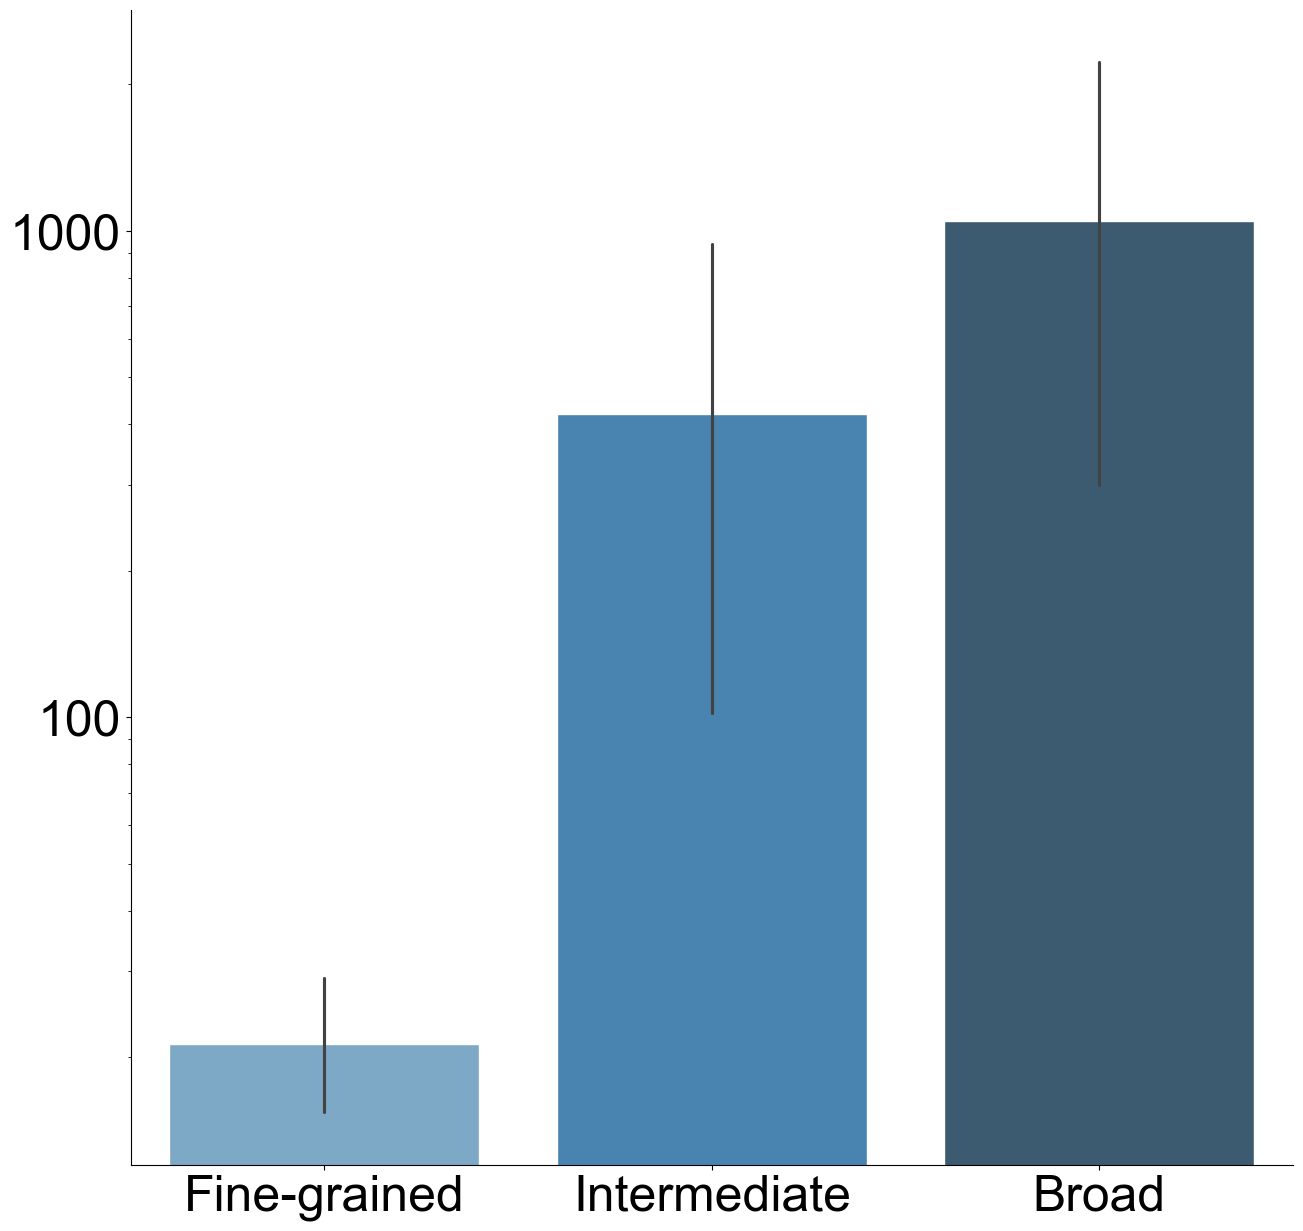

In [4]:
column_names = ["Exposure size", "infomap Iteration"]
labels=['Fine-grained','Intermediate','Broad']
exposuresize_list_tot=[]
group_list=[]
for i in fine_grained_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Fine-grained")
    
for i in middle_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Intermediate")

for i in broad_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Broad")
    
EEN_infomap_com_df = pd.DataFrame(columns = column_names)
EEN_infomap_com_df["Exposure size"]=exposuresize_list_tot
EEN_infomap_com_df["Infomap Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")


ax = sns.barplot(x="Infomap Iteration", y="Exposure size", data=EEN_infomap_com_df, estimator=np.mean,
                 palette="Blues_d")

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
plt.yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('output/Figures/SF17A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [5]:
# Build dataframe exactly matching what is plotted
EEN_infomap_com_df = pd.DataFrame({
    "Exposure_size": exposuresize_list_tot,
    "Infomap_iteration": group_list
})

In [6]:
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    EEN_infomap_com_df.to_excel(
        writer,
        sheet_name="SF23A",
        index=False
    )

print("Source data appended for Louvain community size barplot.")

Source data appended for Louvain community size barplot.


In [ ]:

#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_first_infomap_cluster_genelist={}
for com,explist in ee_first_infomap_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_first_infomap_cluster_genelist[com]=rank_genelist

pre_rank_first_infomap_cluster_genelist_df={}
for com,genelist in pre_rank_first_infomap_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_first_infomap_cluster_genelist_df[com]=rank_df

pre_rank_second_infomap_cluster_genelist={}
for com,explist in ee_second_infomap_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_second_infomap_cluster_genelist[com]=rank_genelist

pre_rank_second_infomap_cluster_genelist_df={}
for com,genelist in pre_rank_second_infomap_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_second_infomap_cluster_genelist_df[com]=rank_df

pre_rank_third_infomap_cluster_genelist={}
for com,explist in ee_third_infomap_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_third_infomap_cluster_genelist[com]=rank_genelist

pre_rank_third_infomap_cluster_genelist_df={}
for com,genelist in pre_rank_third_infomap_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_third_infomap_cluster_genelist_df[com]=rank_df



first_infomap_cluster_genes = {}
second_infomap_cluster_genes = {}
third_infomap_cluster_genes = {}

for com in list(pre_rank_first_infomap_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_first_infomap_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_first_infomap_cluster_genelist_df[com],library_list))
            first_infomap_cluster_genes[com] = lead_genelist
        except:
            first_infomap_cluster_genes[com] = list(pre_rank_first_infomap_cluster_genelist_df[com]["gene"])
    else:
        first_infomap_cluster_genes[com] = list(pre_rank_first_infomap_cluster_genelist_df[com]["gene"])

#Second infomap interation
for com in list(pre_rank_second_infomap_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_second_infomap_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_second_infomap_cluster_genelist_df[com],library_list))
            second_infomap_cluster_genes[com] = lead_genelist
        except:
            second_infomap_cluster_genes[com] = list(pre_rank_second_infomap_cluster_genelist_df[com]["gene"])
    else:
        second_infomap_cluster_genes[com] = list(pre_rank_second_infomap_cluster_genelist_df[com]["gene"])
        
#Third infomap interation
for com in list(pre_rank_third_infomap_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_third_infomap_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_third_infomap_cluster_genelist_df[com],library_list))
            third_infomap_cluster_genes[com] = lead_genelist
        except:
            third_infomap_cluster_genes[com] = list(pre_rank_third_infomap_cluster_genelist_df[com]["gene"])
    else:
        third_infomap_cluster_genes[com] = list(pre_rank_third_infomap_cluster_genelist_df[com]["gene"])

        
import json
# Save the JSON data to a file
with open("output/Communities/Infomap/first_infomap_cluster_genes.json", "w") as f:
    json.dump(first_infomap_cluster_genes, f)
with open("output/Communities/Infomap/second_infomap_cluster_genes.json", "w") as f:
    json.dump(second_infomap_cluster_genes, f)
with open("output/Communities/Infomap/third_infomap_cluster_genes.json", "w") as f:
    json.dump(third_infomap_cluster_genes, f)

In [ ]:
#The enrichment is calculated in the R notebooks: Infomap_GO_ORA, and Infomap_GO_Reactome



In [9]:
first_infomap_ora_dict = read_json_to_dict("output/Communities/Infomap/first_infomap_ora_dict.json")
second_infomap_ora_dict = read_json_to_dict("output/Communities/Infomap/second_infomap_cluster_ora_dict.json")
third_infomap_ora_dict = read_json_to_dict("output/Communities/Infomap/third_infomap_cluster_ora_dict.json")

first_infomap_ora_reactome_dict = read_json_to_dict("output/Communities/Infomap/first_infomap_ora_reactome_dict.json")
second_infomap_ora_reactome_dict = read_json_to_dict("output/Communities/Infomap/second_infomap_cluster_ora_reactome_dict.json")
third_infomap_ora_reactome_dict = read_json_to_dict("output/Communities/Infomap/third_infomap_cluster_ora_reactome_dict.json")

In [10]:

sig_enr_GOBP_third_infomap_ora_dict = {}
sig_enr_GOMF_third_infomap_ora_dict = {}
sig_enr_GOCC_third_infomap_ora_dict = {}
for com,enr_df in third_infomap_ora_dict.items():
    gobp_list = []
    gomf_list = []
    gocc_list = []
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                gobp_list.append(term)
            elif "GOMF" in term:
                gomf_list.append(term)
            elif "GOCC" in term:
                gocc_list.append(term)
    sig_enr_GOBP_third_infomap_ora_dict[com] = gobp_list
    sig_enr_GOMF_third_infomap_ora_dict[com] = gomf_list
    sig_enr_GOCC_third_infomap_ora_dict[com] = gocc_list

sig_enr_GOBP_second_infomap_ora_dict = {}
sig_enr_GOMF_second_infomap_ora_dict = {}
sig_enr_GOCC_second_infomap_ora_dict = {}
for com,enr_df in second_infomap_ora_dict.items():
    gobp_list = []
    gomf_list = []
    gocc_list = []
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                gobp_list.append(term)
            elif "GOMF" in term:
                gomf_list.append(term)
            elif "GOCC" in term:
                gocc_list.append(term)
    sig_enr_GOBP_second_infomap_ora_dict[com] = gobp_list
    sig_enr_GOMF_second_infomap_ora_dict[com] = gomf_list
    sig_enr_GOCC_second_infomap_ora_dict[com] = gocc_list

sig_enr_GOBP_first_infomap_ora_dict = {}
sig_enr_GOMF_first_infomap_ora_dict = {}
sig_enr_GOCC_first_infomap_ora_dict = {}
for com,enr_df in first_infomap_ora_dict.items():
    gobp_list = []
    gomf_list = []
    gocc_list = []
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                gobp_list.append(term)
            elif "GOMF" in term:
                gomf_list.append(term)
            elif "GOCC" in term:
                gocc_list.append(term)
    sig_enr_GOBP_first_infomap_ora_dict[com] = gobp_list
    sig_enr_GOMF_first_infomap_ora_dict[com] = gomf_list
    sig_enr_GOCC_first_infomap_ora_dict[com] = gocc_list


sig_enr_reactome_third_infomap_ora_dict = {}
for com,enr_df in third_infomap_ora_reactome_dict.items():
    sig_term_list = enr_df[enr_df["FDR"]<0.05]["Description"].tolist()
    sig_enr_reactome_third_infomap_ora_dict[com] = sig_term_list

sig_enr_reactome_second_infomap_ora_dict = {}
for com,enr_df in second_infomap_ora_reactome_dict.items():
    sig_term_list = enr_df[enr_df["FDR"]<0.05]["Description"].tolist()
    sig_enr_reactome_second_infomap_ora_dict[com] = sig_term_list

sig_enr_reactome_first_infomap_ora_dict = {}
for com,enr_df in first_infomap_ora_reactome_dict.items():
    try:
        sig_term_list = enr_df[enr_df["FDR"]<0.05]["Description"].tolist()
        sig_enr_reactome_first_infomap_ora_dict[com] = sig_term_list
    except:
        sig_enr_reactome_first_infomap_ora_dict[com] = []


In [11]:
broad_sig_enr_df = pd.DataFrame()
lib_list = []
com_list = []
enr_list = []
fdr_list = []
for com,enr_df in third_infomap_ora_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                lib_list.append("GO BP")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOMF" in term:
                lib_list.append("GO MF")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOCC" in term:
                lib_list.append("GO CC")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])


for com,enr_df in third_infomap_ora_reactome_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            lib_list.append("Reactome")
            enr_list.append(term)
            com_list.append(com)
            fdr_list.append(v["FDR"])


broad_sig_enr_df["Library"] = lib_list
broad_sig_enr_df["Community"] = com_list
broad_sig_enr_df["Terms"] = enr_list
broad_sig_enr_df["FDR"] = fdr_list



In [12]:
middle_sig_enr_df = pd.DataFrame()
lib_list = []
com_list = []
enr_list = []
fdr_list = []
for com,enr_df in second_infomap_ora_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                lib_list.append("GO BP")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOMF" in term:
                lib_list.append("GO MF")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOCC" in term:
                lib_list.append("GO CC")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])


for com,enr_df in second_infomap_ora_reactome_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            lib_list.append("Reactome")
            enr_list.append(term)
            com_list.append(com)
            fdr_list.append(v["FDR"])


middle_sig_enr_df["Library"] = lib_list
middle_sig_enr_df["Community"] = com_list
middle_sig_enr_df["Terms"] = enr_list
middle_sig_enr_df["FDR"] = fdr_list


In [13]:
fine_sig_enr_df = pd.DataFrame()
lib_list = []
com_list = []
enr_list = []
fdr_list = []
for com,enr_df in first_infomap_ora_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                lib_list.append("GO BP")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOMF" in term:
                lib_list.append("GO MF")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOCC" in term:
                lib_list.append("GO CC")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])


for com,enr_df in first_infomap_ora_reactome_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            lib_list.append("Reactome")
            enr_list.append(term)
            com_list.append(com)
            fdr_list.append(v["FDR"])


fine_sig_enr_df["Library"] = lib_list
fine_sig_enr_df["Community"] = com_list
fine_sig_enr_df["Terms"] = enr_list
fine_sig_enr_df["FDR"] = fdr_list


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2915631881.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)


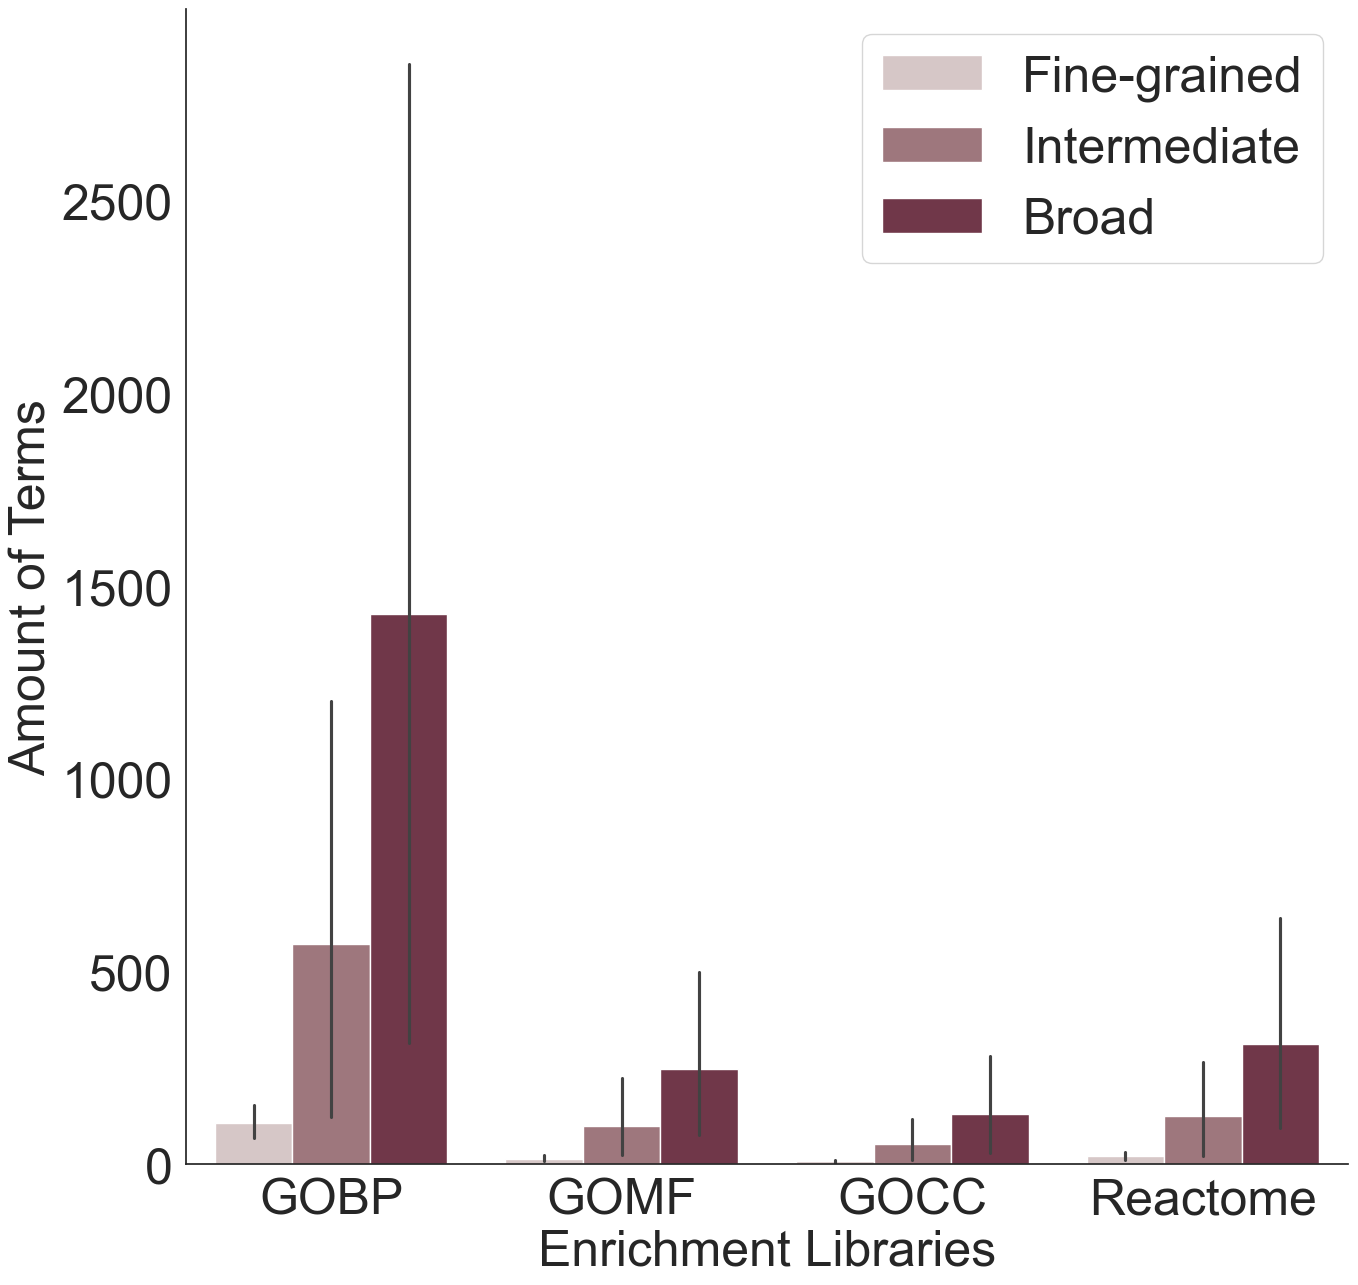

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

go_com_df=pd.DataFrame()

status_list=[]
num_terms_list=[]
level_list=[]

for com,enr_list in sig_enr_GOBP_first_infomap_ora_dict.items():
    status_list.append("GOBP")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")
    
for com,enr_list in sig_enr_GOMF_first_infomap_ora_dict.items():
    status_list.append("GOMF")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")
    
for com,enr_list in sig_enr_GOCC_first_infomap_ora_dict.items():
    status_list.append("GOCC")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")
    
for com,enr_list in sig_enr_reactome_first_infomap_ora_dict.items():
    status_list.append("Reactome")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")

for com,enr_list in sig_enr_GOBP_second_infomap_ora_dict.items():
    status_list.append("GOBP")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")
    
for com,enr_list in sig_enr_GOMF_second_infomap_ora_dict.items():
    status_list.append("GOMF")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")
    
for com,enr_list in sig_enr_GOCC_second_infomap_ora_dict.items():
    status_list.append("GOCC")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")
    
for com,enr_list in sig_enr_reactome_second_infomap_ora_dict.items():
    status_list.append("Reactome")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")

for com,enr_list in sig_enr_GOBP_third_infomap_ora_dict.items():
    status_list.append("GOBP")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")
    
for com,enr_list in sig_enr_GOMF_third_infomap_ora_dict.items():
    status_list.append("GOMF")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")
    
for com,enr_list in sig_enr_GOCC_third_infomap_ora_dict.items():
    status_list.append("GOCC")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")
    
for com,enr_list in sig_enr_reactome_third_infomap_ora_dict.items():
    status_list.append("Reactome")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")


go_com_df['Status']=status_list
go_com_df['Enriched Terms']=num_terms_list
go_com_df['Hierarchy']=level_list


# Create a boxplot using seaborn
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x='Status', y='Enriched Terms', hue='Hierarchy', estimator='mean',palette=['#D8C4C5','#A47179','#7A2D45'],data=go_com_df)
#g.set_yscale("log")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)
plt.xticks(fontsize=36)

plt.xlabel('Enrichment Libraries', fontsize=36)
plt.ylabel('Amount of Terms', fontsize=36)
plt.legend(fontsize=36)
#plt.savefig('Figures/Fig17B_v01_post_rev.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()

In [15]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    go_com_df.to_excel(
        writer,
        sheet_name="SF23B",
        index=False
    )

In [ ]:
#Here, we will define a funnction that calculates the lcc for each set of terms in the GO tree to check for the 
#cohesiveness of the enrichment terms in each community
def lcc_significance(term_list,network):
    import random as rd
    import numpy as np
    z='nan'
    if len(set(term_list))>1:
        try:
            G_sub = nx.subgraph(network,term_list)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            f_lcc_size = G_sub_lcc.number_of_nodes()
        except:
            f_lcc_size = 1
            
        l_random_lccs = []

        S = 1000
        for s in range(S):
            term_sample = rd.sample(list(network.nodes()),len(set(term_list)))
            G_sub_rnd = nx.subgraph(network,term_sample)
            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = (f_lcc_size-mu)/std
    
    return z


In [ ]:
#https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp#C5
#
#https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/
import json

def read_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

# Example usage:
json_file = 'input/Libraries/c5.go.v2023.1.Hs.json'
go_gsea_file = read_json(json_file)

go_match_id_dict = {}
for key,description_dict in go_gsea_file.items():
    up_key = key.replace("_"," ")
    go_match_id_dict[up_key]= description_dict["exactSource"]


In [ ]:
sig_enr_id_GOMF_third_infomap_ora_dict = {}
sig_enr_id_GOBP_third_infomap_ora_dict = {}
sig_enr_id_GOCC_third_infomap_ora_dict = {}

for com,enr_list in sig_enr_GOBP_third_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOBP_third_infomap_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOMF_third_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOMF_third_infomap_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOCC_third_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOCC_third_infomap_ora_dict[com] = n_term_list

sig_enr_id_GOMF_second_infomap_ora_dict = {}
sig_enr_id_GOBP_second_infomap_ora_dict = {}
sig_enr_id_GOCC_second_infomap_ora_dict = {}

for com,enr_list in sig_enr_GOBP_second_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOBP_second_infomap_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOMF_second_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOMF_second_infomap_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOCC_second_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOCC_second_infomap_ora_dict[com] = n_term_list


sig_enr_id_GOMF_first_infomap_ora_dict = {}
sig_enr_id_GOBP_first_infomap_ora_dict = {}
sig_enr_id_GOCC_first_infomap_ora_dict = {}

for com,enr_list in sig_enr_GOBP_first_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOBP_first_infomap_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOMF_first_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOMF_first_infomap_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOCC_first_infomap_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOCC_first_infomap_ora_dict[com] = n_term_list


In [ ]:

with open('output/Communities/Infomap/sig_enr_id_GOMF_third_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOMF_third_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/sig_enr_id_GOBP_third_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOBP_third_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/sig_enr_id_GOCC_third_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOCC_third_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Infomap/sig_enr_id_GOMF_second_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOMF_second_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/sig_enr_id_GOBP_second_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOBP_second_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/sig_enr_id_GOCC_second_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOCC_second_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)



with open('output/Communities/Infomap/sig_enr_id_GOMF_first_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOMF_first_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/sig_enr_id_GOBP_first_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOBP_first_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/sig_enr_id_GOCC_first_infomap_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOCC_first_infomap_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


In [ ]:
#Let's import the latest release of the GO ontology
import obonet

url = 'http://purl.obolibrary.org/obo/go.obo'
graph = obonet.read_obo(url)
graph_up = nx.DiGraph.reverse(graph)

In [ ]:
#BP
GOBP = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0008150')))
GOBP_undirected=GOBP.to_undirected()
#MF
GOMF = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0003674')))
GOMF_undirected=GOMF.to_undirected()
#CC
GOCC = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0005575')))
GOCC_undirected=GOCC.to_undirected()


In [ ]:

sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOBP_first_infomap_ora_dict.items():
    sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOBP_undirected)

sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOMF_first_infomap_ora_dict.items():
    sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOMF_undirected)

sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOCC_first_infomap_ora_dict.items():
    sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOCC_undirected)

sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOBP_second_infomap_ora_dict.items():
    sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOBP_undirected)

sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOMF_second_infomap_ora_dict.items():
    sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOMF_undirected)

sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOCC_second_infomap_ora_dict.items():
    sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOCC_undirected)

sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOBP_third_infomap_ora_dict.items():
    sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOBP_undirected)

sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOMF_third_infomap_ora_dict.items():
    sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOMF_undirected)

sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOCC_third_infomap_ora_dict.items():
    sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOCC_undirected)
    

In [ ]:

with open('output/Communities/Infomap/sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Infomap/sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Infomap/sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


In [3]:
import pickle as pk

with open('output/Communities/Infomap/sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict = pk.load(handle)

with open('output/Communities/Infomap/sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict = pk.load(handle)
    
with open('output/Communities/Infomap/sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict = pk.load(handle)


with open('output/Communities/Infomap/sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict = pk.load(handle)

with open('output/Communities/Infomap/sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict = pk.load(handle)
    
with open('output/Communities/Infomap/sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict = pk.load(handle)


with open('output/Communities/Infomap/sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict = pk.load(handle)

with open('output/Communities/Infomap/sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict = pk.load(handle)
    
with open('output/Communities/Infomap/sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict = pk.load(handle)

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/3851505443.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/3851505443.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

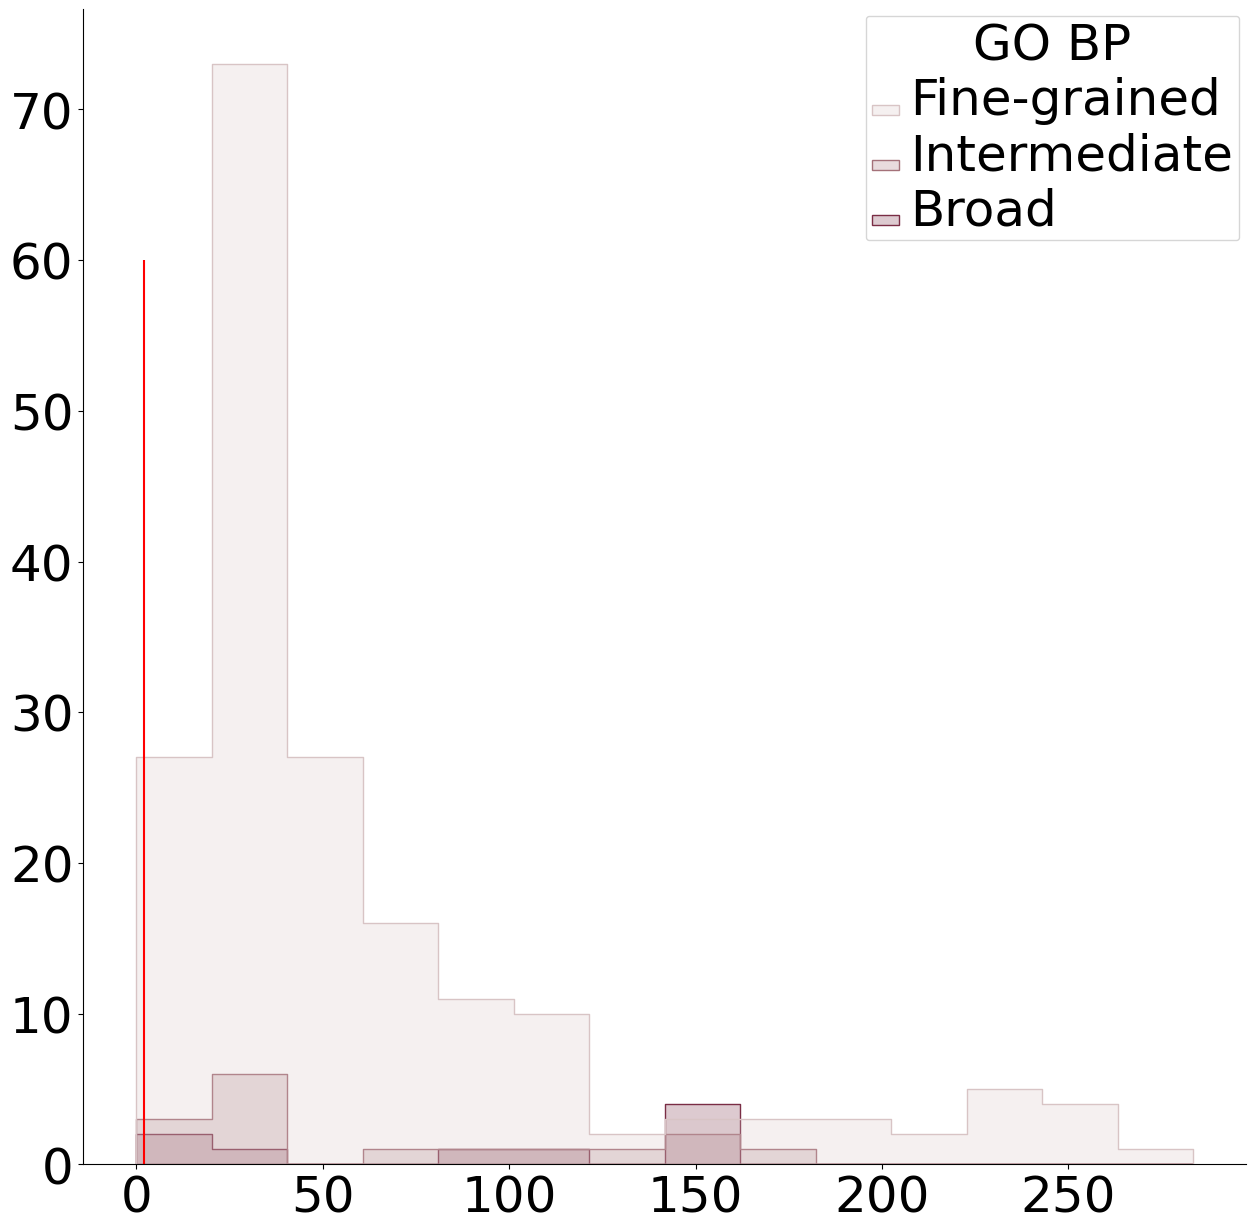

In [4]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_BP_lcc_zscore=[]
iteration=[]
for com, zscore in sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_BP_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_BP_lcc_zscore=[]

for com, zscore in sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_BP_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_BP_lcc_zscore=[]

for com, zscore in sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_BP_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_BP_lcc_zscore+middle_BP_lcc_zscore+broad_BP_lcc_zscore
goterms_lcc_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=60,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO BP", element="step",palette=['#D8C4C5','#A47179','#7A2D45'],
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF17C_1_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")



In [ ]:

records = []

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

# Fine-grained
for com, zscore in sig_enr_GOBP_first_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_BP_group": "Fine-grained",
            "Color": palette_map["Fine-grained"]
        })

# Intermediate
for com, zscore in sig_enr_GOBP_second_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_BP_group": "Intermediate",
            "Color": palette_map["Intermediate"]
        })

# Broad
for com, zscore in sig_enr_GOBP_third_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_BP_group": "Broad",
            "Color": palette_map["Broad"]
        })

# Create dataframe
SF_GOBP_lcc_source_df = pd.DataFrame(records)
SF_GOBP_lcc_source_df = SF_GOBP_lcc_source_df.dropna()

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    SF_GOBP_lcc_source_df.to_excel(
        writer,
        sheet_name="SF23D_part1",
        index=False
    )

print("Source data appended: GO_BP_LCC_Zscores")

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/1145316909.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/1145316909.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

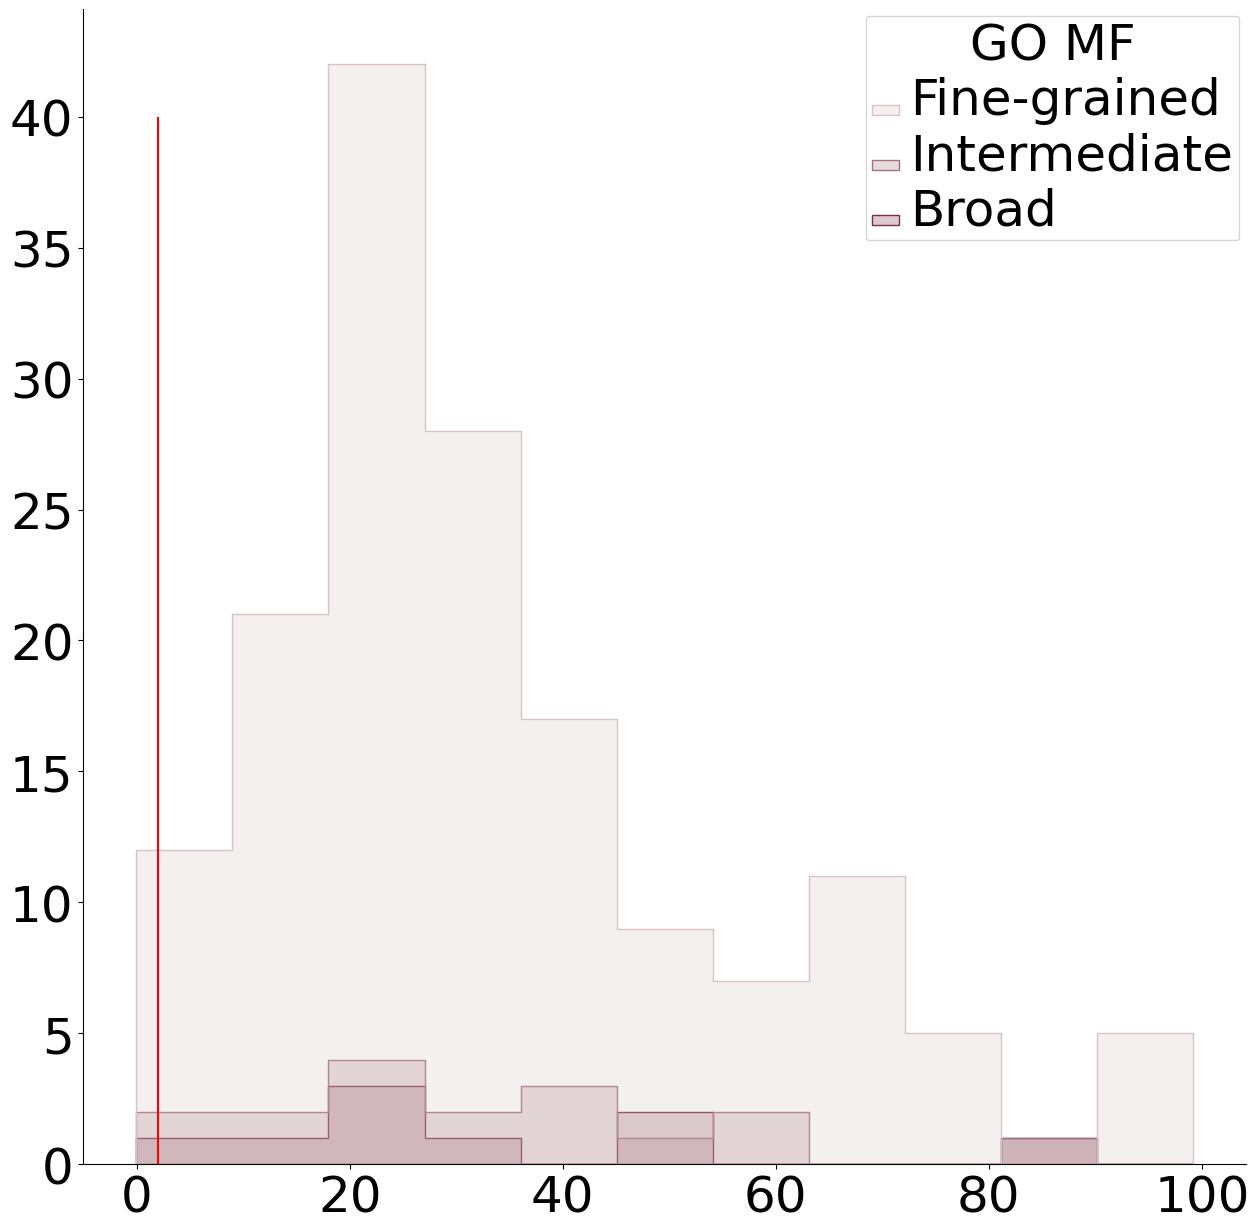

In [6]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_MF_lcc_zscore=[]
iteration=[]
for com, zscore in sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_MF_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_MF_lcc_zscore=[]

for com, zscore in sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_MF_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_MF_lcc_zscore=[]

for com, zscore in sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_MF_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_MF_lcc_zscore+middle_MF_lcc_zscore+broad_MF_lcc_zscore
goterms_lcc_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO MF", element="step",palette=['#D8C4C5','#A47179','#7A2D45'],
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF17C_2_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [20]:

records = []

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

# Fine-grained
for com, zscore in sig_enr_GOMF_first_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_MF_group": "Fine-grained",
            "Color": palette_map["Fine-grained"]
        })

# Intermediate
for com, zscore in sig_enr_GOMF_second_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_MF_group": "Intermediate",
            "Color": palette_map["Intermediate"]
        })

# Broad
for com, zscore in sig_enr_GOMF_third_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_MF_group": "Broad",
            "Color": palette_map["Broad"]
        })

# Create dataframe
SF_GOMF_lcc_source_df = pd.DataFrame(records)
SF_GOMF_lcc_source_df = SF_GOMF_lcc_source_df.dropna()

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    SF_GOMF_lcc_source_df.to_excel(
        writer,
        sheet_name="SF23D_part2",
        index=False
    )

print("Source data appended: GO_MF_LCC_Zscores")

Source data appended: GO_MF_LCC_Zscores


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/2206791284.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/2206791284.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

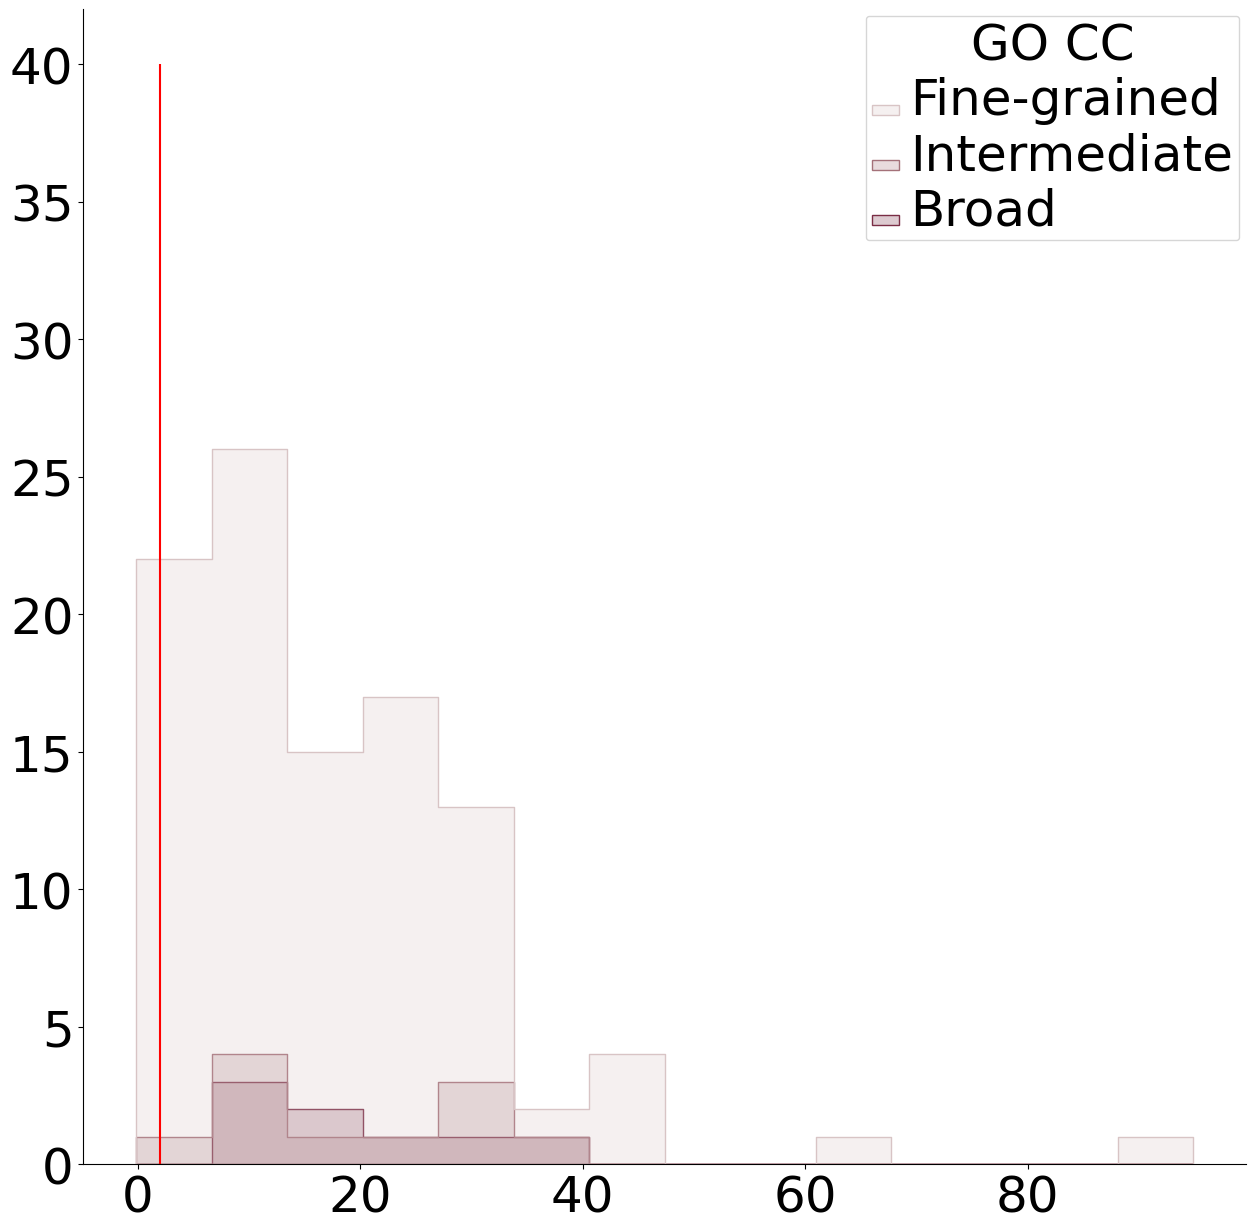

In [7]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_CC_lcc_zscore=[]
iteration=[]
for com, zscore in sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_CC_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_CC_lcc_zscore=[]

for com, zscore in sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_CC_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_CC_lcc_zscore=[]

for com, zscore in sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_CC_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_CC_lcc_zscore+middle_CC_lcc_zscore+broad_CC_lcc_zscore
goterms_lcc_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO CC", element="step",palette=['#D8C4C5','#A47179','#7A2D45'],
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('Figures/SF17C_3_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [22]:

records = []

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

# Fine-grained
for com, zscore in sig_enr_GOCC_first_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_CC_group": "Fine-grained",
            "Color": palette_map["Fine-grained"]
        })

# Intermediate
for com, zscore in sig_enr_GOCC_second_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_CC_group": "Intermediate",
            "Color": palette_map["Intermediate"]
        })

# Broad
for com, zscore in sig_enr_GOCC_third_infomap_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_CC_group": "Broad",
            "Color": palette_map["Broad"]
        })

# Create dataframe
SF_GOCC_lcc_source_df = pd.DataFrame(records)
SF_GOCC_lcc_source_df = SF_GOCC_lcc_source_df.dropna()

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    SF_GOCC_lcc_source_df.to_excel(
        writer,
        sheet_name="SF23D_part3",
        index=False
    )

print("Source data appended: GO_CC_LCC_Zscores")

Source data appended: GO_CC_LCC_Zscores


In [8]:
finegrained_enriched_terms=finegrained_BP_lcc_zscore+finegrained_MF_lcc_zscore+finegrained_CC_lcc_zscore
middle_enriched_terms=middle_BP_lcc_zscore+middle_MF_lcc_zscore+middle_CC_lcc_zscore
broad_enriched_terms=broad_BP_lcc_zscore+broad_MF_lcc_zscore+broad_CC_lcc_zscore


In [ ]:
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_enriched_terms,middle_enriched_terms)
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,middle_enriched_terms)
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,finegrained_enriched_terms)
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

In [ ]:
#Mann-Whitney U test two-sided 

u_statistic, p_value = stats.mannwhitneyu(middle_enriched_terms,finegrained_enriched_terms, alternative='two-sided')
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)

u_statistic, p_value = stats.mannwhitneyu(broad_enriched_terms, middle_enriched_terms, alternative='two-sided')
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)

u_statistic, p_value = stats.mannwhitneyu(broad_enriched_terms, finegrained_enriched_terms, alternative='two-sided')
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/2519363939.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.barplot(x=EEN_infomap_com_df["infomap Iteration"], y=EEN_infomap_com_df["z-score lcc"],estimator=np.median,palette=['#D8C4C5','#A47179','#7A2D45'],linewidth=5)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/2519363939.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_31795/2519363939.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


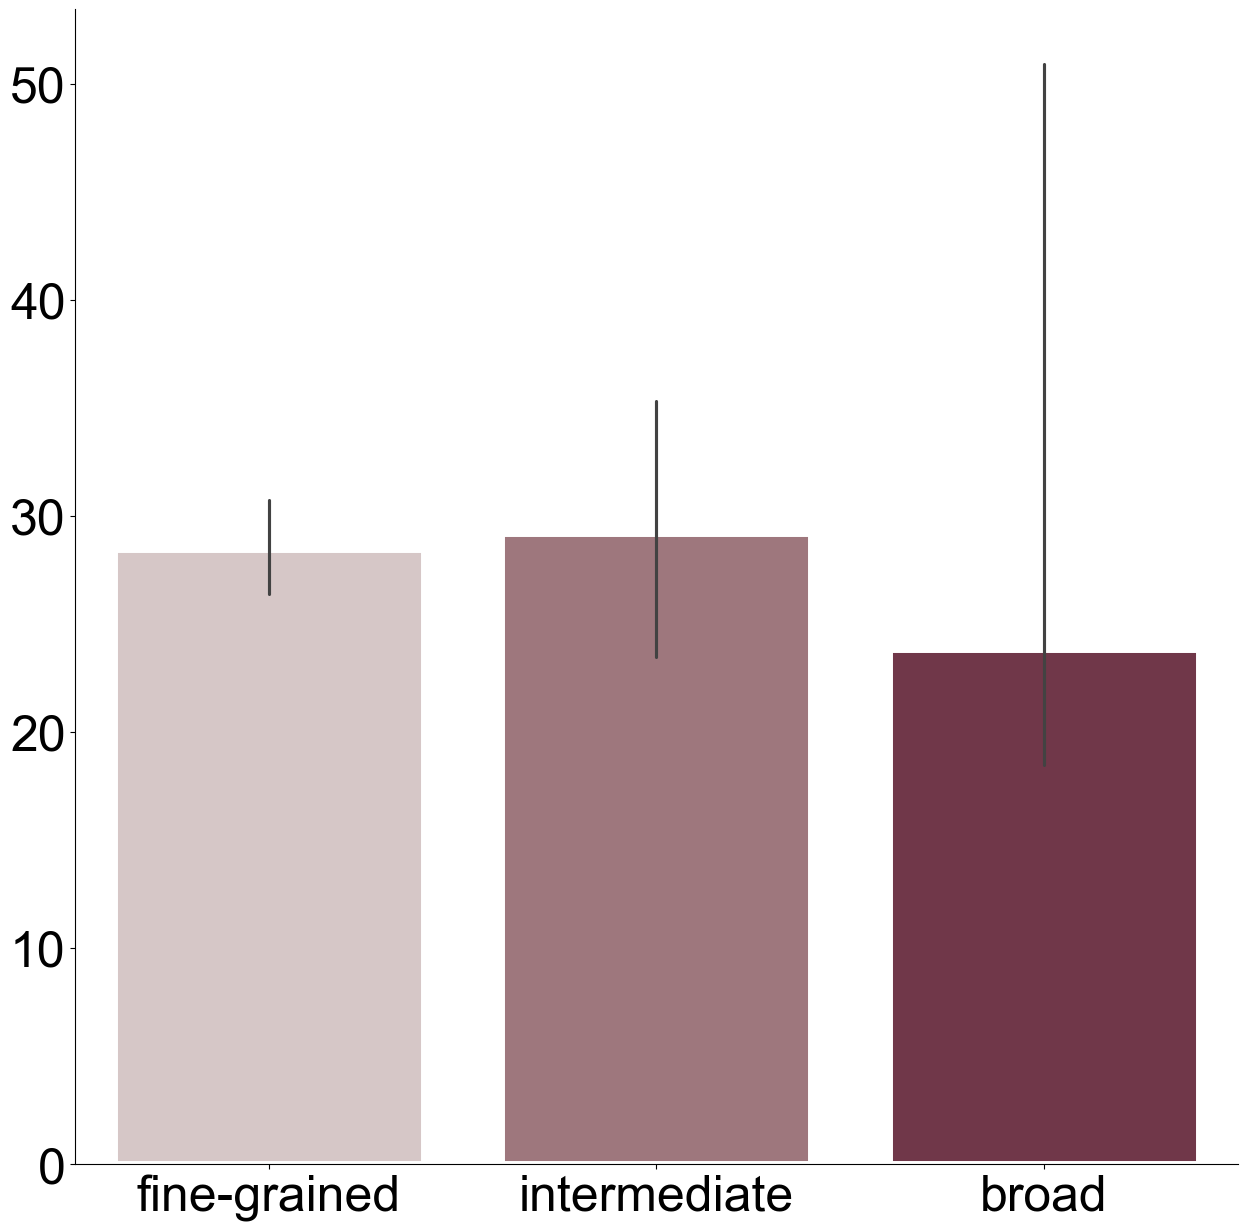

In [9]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["z-score lcc", "infomap Iteration"]
labels=['fine-grained','intermediate','broad']
zscore_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("broad")
    
EEN_infomap_com_df = pd.DataFrame(columns = column_names)
EEN_infomap_com_df["z-score lcc"]=zscore_list_tot
EEN_infomap_com_df["infomap Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_infomap_com_df["infomap Iteration"], y=EEN_infomap_com_df["z-score lcc"],estimator=np.median,palette=['#D8C4C5','#A47179','#7A2D45'],linewidth=5)

#ax = sns.barplot(x="infomap Iteration", y="z-score lcc", data=EEN_infomap_com_df,
#                 palette="Blues_d")
#g.set_yscale("log")
#ax.set_xlabel("infomap iteration",fontsize=32)
#ax.set_ylabel("lcc z-score enriched terms",fontsize=32)
ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('output/Figures/SF17D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [10]:
#EEN_infomap_com_df.drop(columns=["infomap Iteration"], inplace=True)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    EEN_infomap_com_df.to_excel(
        writer,
        sheet_name="SF23C",
        index=False
    )

In [ ]:
#T-test
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between fine-grained and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between broad and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,finegrained_MF_lcc_zscore)
print("The p-value between broad and fine-grained communities of MF z-score distributions is %s" %p_value)


t_value,p_value=stats.ttest_ind(finegrained_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between fine-grained and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between broad and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,finegrained_BP_lcc_zscore)
print("The p-value between broad and fine-grained communities of BP z-score distributions is %s" %p_value)

t_value,p_value=stats.ttest_ind(finegrained_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between fine-grained and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between broad and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,finegrained_CC_lcc_zscore)
print("The p-value between broad and fine-grained communities of CC z-score distributions is %s" %p_value)


In [5]:
import pickle as pk
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd


In [26]:
#Let's import the results
with open('output/Communities/Infomap/weighted_fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Infomap/weighted_middle_communities_gobp_resnik.pickle', 'rb') as handle:
    middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_middle_communities_gomf_resnik.pickle', 'rb') as handle:
    middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_middle_communities_gocc_resnik.pickle', 'rb') as handle:
    middle_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Infomap/weighted_broad_communities_gobp_resnik.pickle', 'rb') as handle:
    broad_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_broad_communities_gomf_resnik.pickle', 'rb') as handle:
    broad_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_broad_communities_gocc_resnik.pickle', 'rb') as handle:
    broad_communities_gocc_resnik = pk.load(handle)

#Let's import the random expectations


with open('output/Communities/Infomap/weighted_rd_fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_rd_middle_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_rd_broad_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gomf_resnik = pk.load(handle)
with open('output/Communities/Infomap/weighted_rd_fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_rd_middle_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_rd_broad_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Infomap/weighted_rd_fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_rd_middle_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/weighted_rd_broad_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gobp_resnik = pk.load(handle)
    

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/3204910312.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/3204910312.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

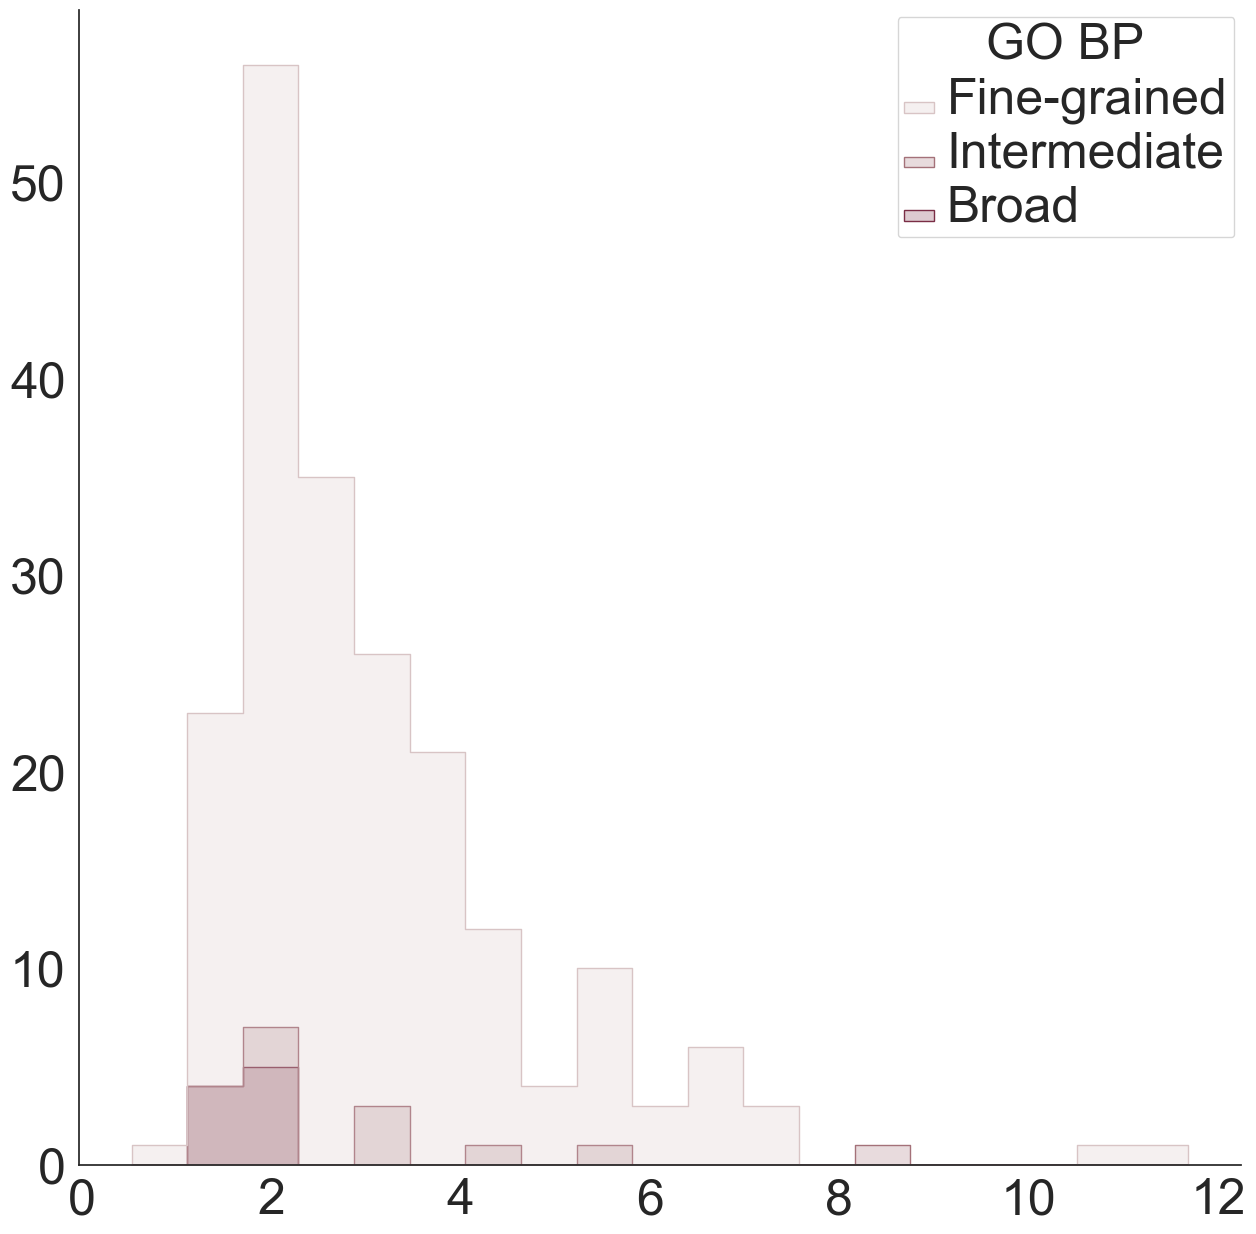

In [27]:
goterms_resnik_df=pd.DataFrame()

finegrained_BP_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_BP_resnik=[]
for com, resnik in middle_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_BP_resnik=[]
for com, resnik in broad_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_BP_resnik+middle_BP_resnik+broad_BP_resnik
goterms_resnik_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')


sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO BP", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF18A_1_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [28]:
palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_df = goterms_resnik_df.dropna()

goterms_resnik_df["Color"] = goterms_resnik_df["GO BP"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    goterms_resnik_df.to_excel(
        writer,
        sheet_name="SF24A_part1",
        index=False
    )

print("Source data appended: SF_GOBP_resnik_df")

Source data appended: SF_GOBP_resnik_df


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/1535756715.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/1535756715.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

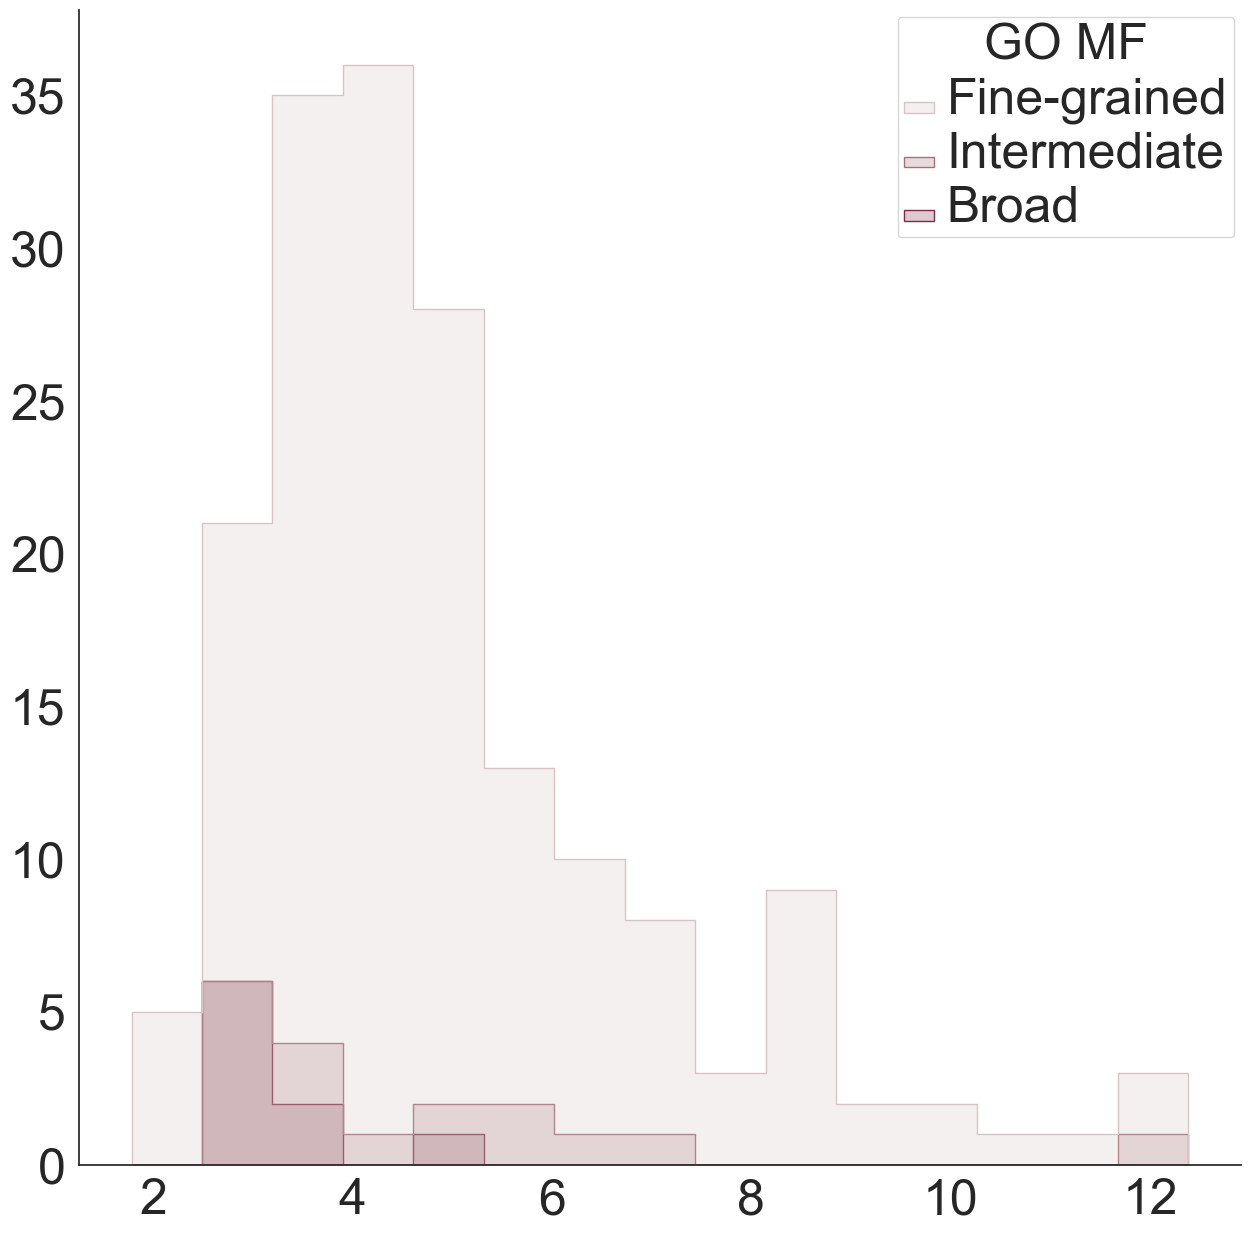

In [29]:
goterms_resnik_df=pd.DataFrame()

finegrained_MF_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_MF_resnik=[]
for com, resnik in middle_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_MF_resnik=[]
for com, resnik in broad_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_MF_resnik+middle_MF_resnik+broad_MF_resnik
goterms_resnik_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO MF", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF18A_2_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [30]:
palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_df = goterms_resnik_df.dropna()

goterms_resnik_df["Color"] = goterms_resnik_df["GO MF"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    goterms_resnik_df.to_excel(
        writer,
        sheet_name="SF24A_part2",
        index=False
    )

print("Source data appended: SF_GOMF_resnik_df")

Source data appended: SF_GOMF_resnik_df


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2061899452.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2061899452.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

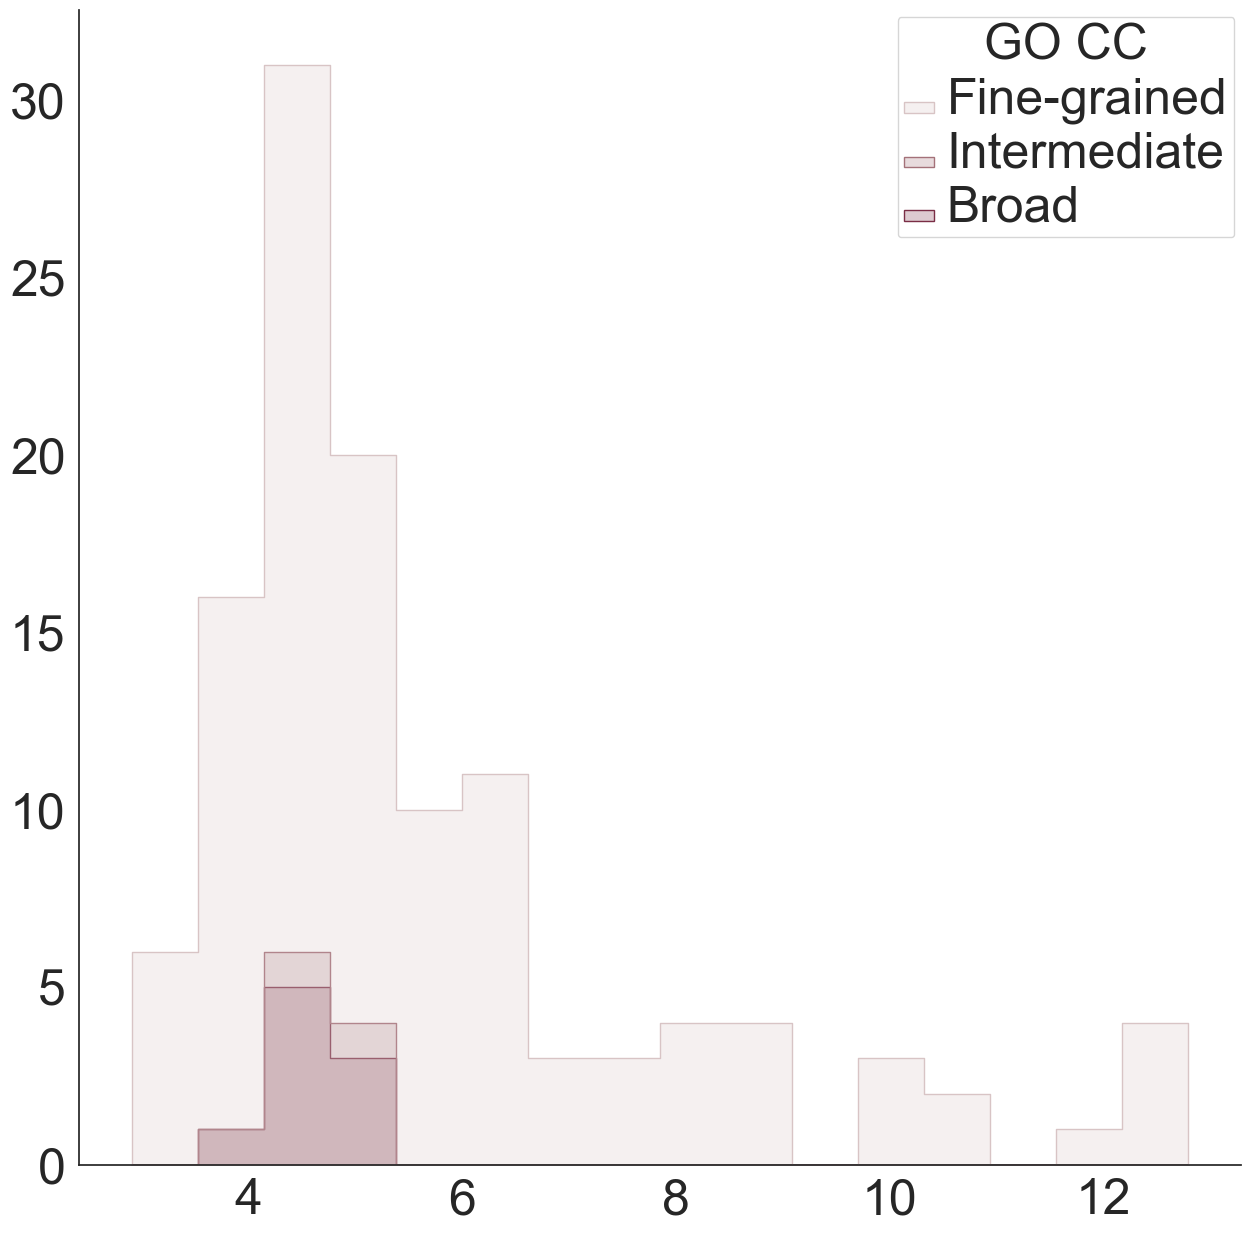

In [31]:
goterms_resnik_df=pd.DataFrame()

finegrained_CC_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_CC_resnik=[]
for com, resnik in middle_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_CC_resnik=[]
for com, resnik in broad_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_CC_resnik+middle_CC_resnik+broad_CC_resnik
goterms_resnik_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO CC", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF18A_3_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [32]:
palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_df = goterms_resnik_df.dropna()

goterms_resnik_df["Color"] = goterms_resnik_df["GO CC"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    goterms_resnik_df.to_excel(
        writer,
        sheet_name="SF24A_part3",
        index=False
    )

print("Source data appended: SF_GOCC_resnik_df")

Source data appended: SF_GOCC_resnik_df


In [33]:
finegrained_enriched_terms_resnik = finegrained_BP_resnik+finegrained_MF_resnik+finegrained_CC_resnik
middle_enriched_terms_resnik = middle_BP_resnik+middle_MF_resnik+middle_CC_resnik
broad_enriched_terms_resnik = broad_BP_resnik+broad_MF_resnik+broad_CC_resnik

finegrained_enriched_terms_resnik_clean = [i for i in finegrained_enriched_terms_resnik if str(i)!='nan']
middle_enriched_terms_resnik_clean = [i for i in middle_enriched_terms_resnik if str(i)!='nan']
broad_enriched_terms_resnik_clean = [i for i in broad_enriched_terms_resnik if str(i)!='nan']

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/1013271945.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/1013271945.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


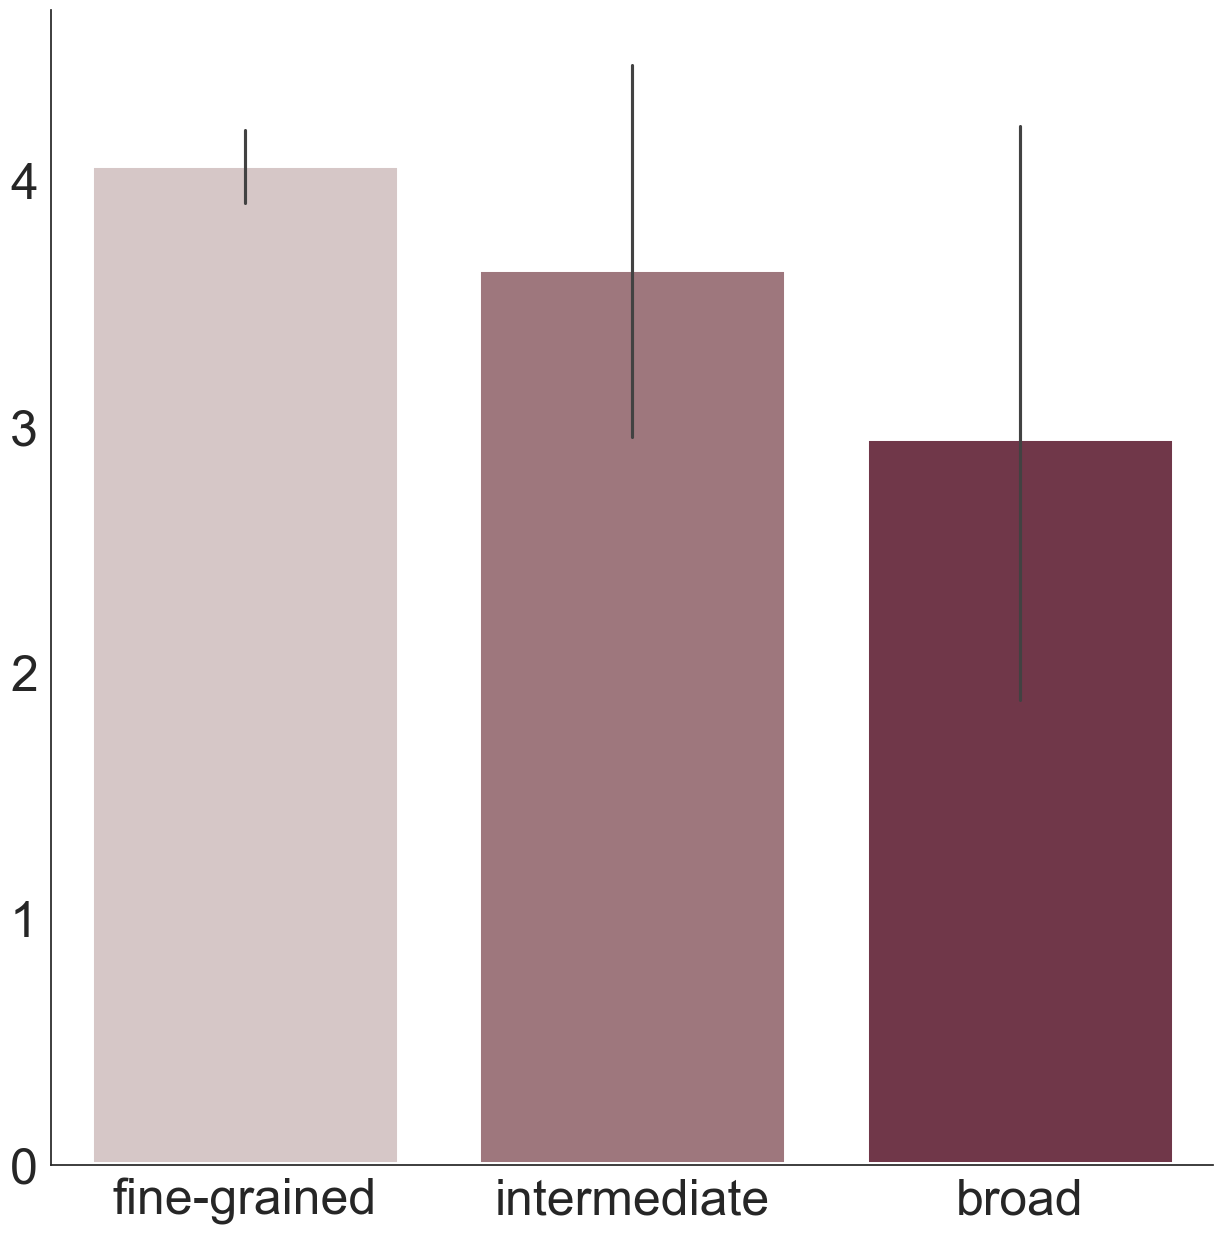

In [34]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community

column_names = ["resnik", "infomap Iteration"]
labels=['fine-grained','intermediate','broad']
resnik_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("broad")
    
EEN_infomap_com_df = pd.DataFrame(columns = column_names)
EEN_infomap_com_df["resnik"]=resnik_list_tot
EEN_infomap_com_df["Infomap Iteration"]=group_list


fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_infomap_com_df["Infomap Iteration"], y=EEN_infomap_com_df["resnik"],estimator=np.median, hue=EEN_infomap_com_df["Infomap Iteration"], palette=['#D8C4C5','#A47179','#7A2D45'],legend=False,linewidth=5)


ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('output/Figures/SF18C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [35]:


records = []

color_map = {
    "fine-grained": "#D8C4C5",
    "intermediate": "#A47179",
    "broad": "#7A2D45"
}

for v in finegrained_enriched_terms_resnik_clean:
    records.append({
        "resnik": float(v),
        "Infomap_iteration": "fine-grained",
        "color": color_map["fine-grained"]
    })

for v in middle_enriched_terms_resnik_clean:
    records.append({
        "resnik": float(v),
        "Infomap_iteration": "intermediate",
        "color": color_map["intermediate"]
    })

for v in broad_enriched_terms_resnik_clean:
    records.append({
        "resnik": float(v),
        "Infomap_iteration": "broad",
        "color": color_map["broad"]
    })

barplot_source_df = pd.DataFrame(records)

# ---------- append BOTH to existing Excel ----------

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    barplot_source_df.to_excel(
        writer,
        sheet_name="SF24C",
        index=False
    )



In [14]:
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between fine-grained and middle communities GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between broad and middle communities of GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,finegrained_enriched_terms_resnik_clean)
print("The p-value between broad and fine-grained communities of GO Resnik distributions is %s" %p_value)

The p-value between fine-grained and middle communities GO Resnik distributions is 0.17665789252586928
The p-value between broad and middle communities of GO Resnik distributions is 0.07018296463753797
The p-value between broad and fine-grained communities of GO Resnik distributions is 0.004252323854139033


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2664316418.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2664316418.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

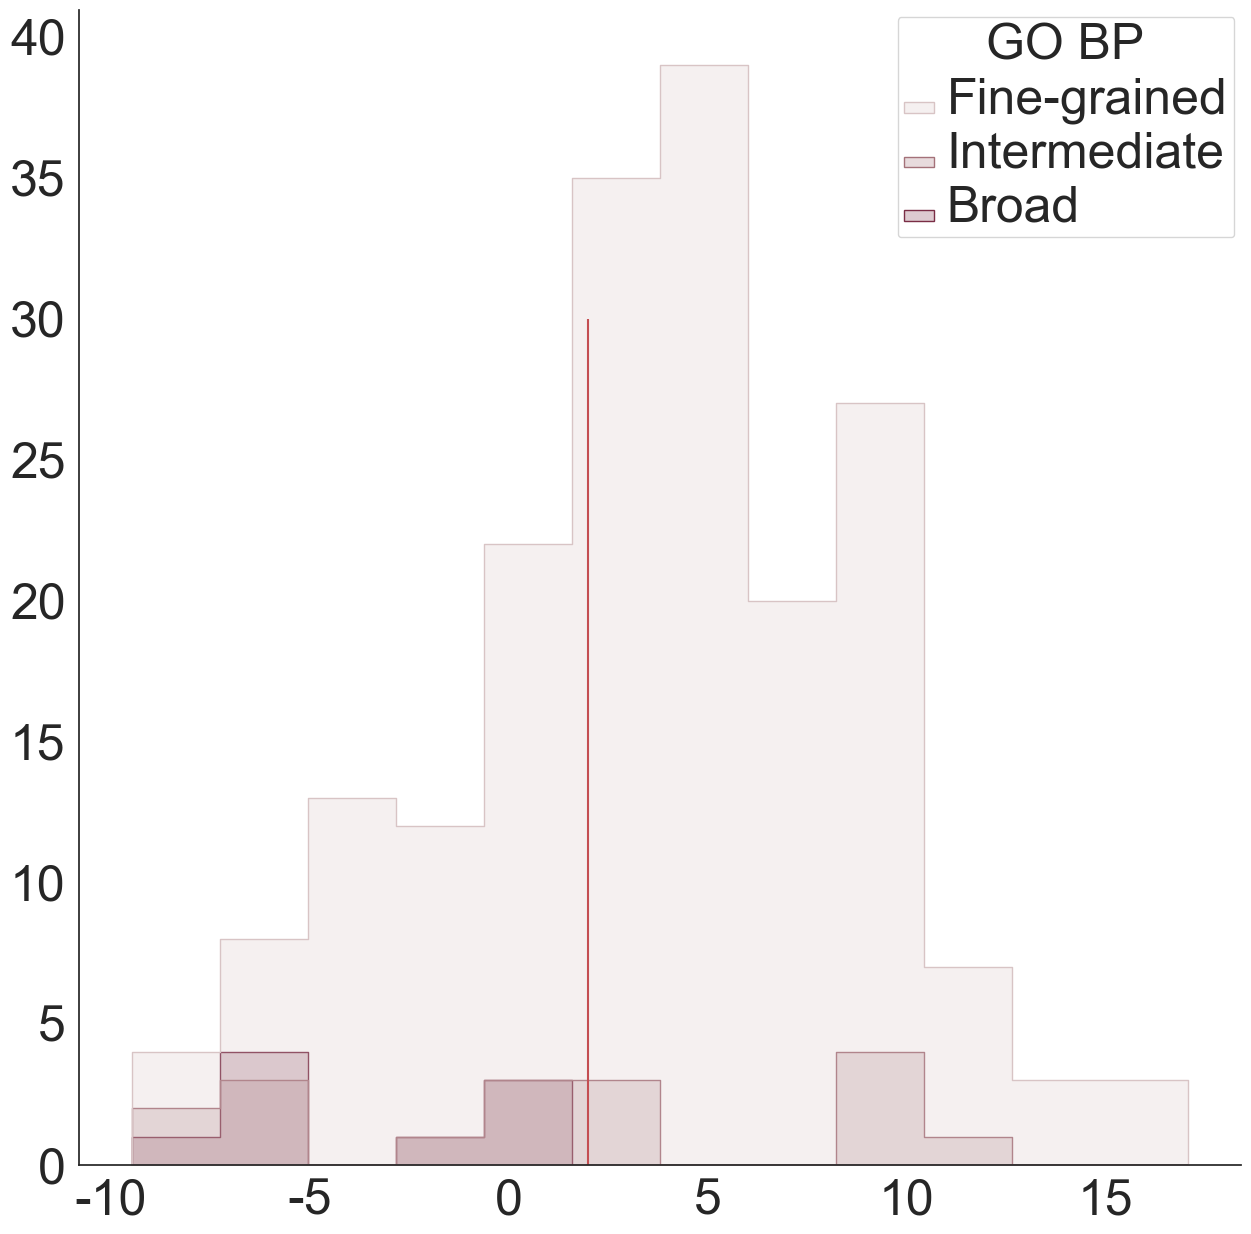

In [36]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_BP_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_BP_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_BP_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_BP_resnik_zscore+middle_BP_resnik_zscore+broad_BP_resnik_zscore
goterms_resnik_zscore_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=30,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO BP", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF18B_1_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [37]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_zscore_df["Color"] = goterms_resnik_zscore_df["GO BP"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    goterms_resnik_zscore_df.to_excel(
        writer,
        sheet_name="SF24B_part1",
        index=False
    )


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/4151067591.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/4151067591.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

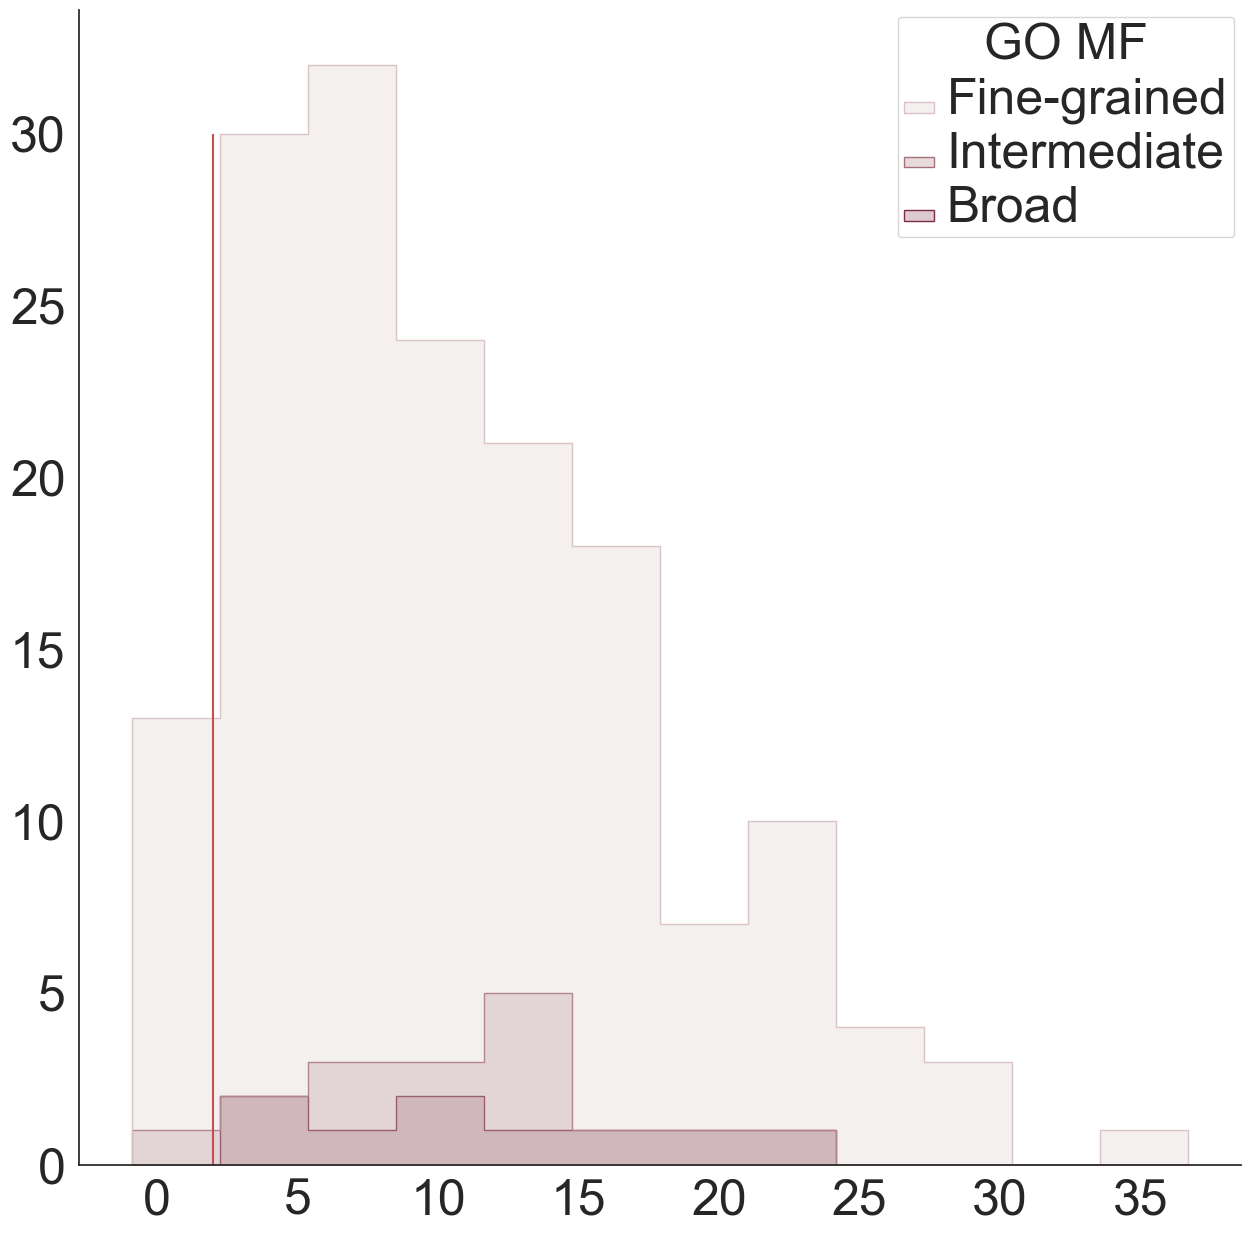

In [38]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_MF_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_MF_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_MF_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_MF_resnik_zscore+middle_MF_resnik_zscore+broad_MF_resnik_zscore
goterms_resnik_zscore_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=30,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO MF", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF18B_2_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [39]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_zscore_df["Color"] = goterms_resnik_zscore_df["GO MF"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    goterms_resnik_zscore_df.to_excel(
        writer,
        sheet_name="SF24B_part2",
        index=False
    )


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2544119170.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_1438/2544119170.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

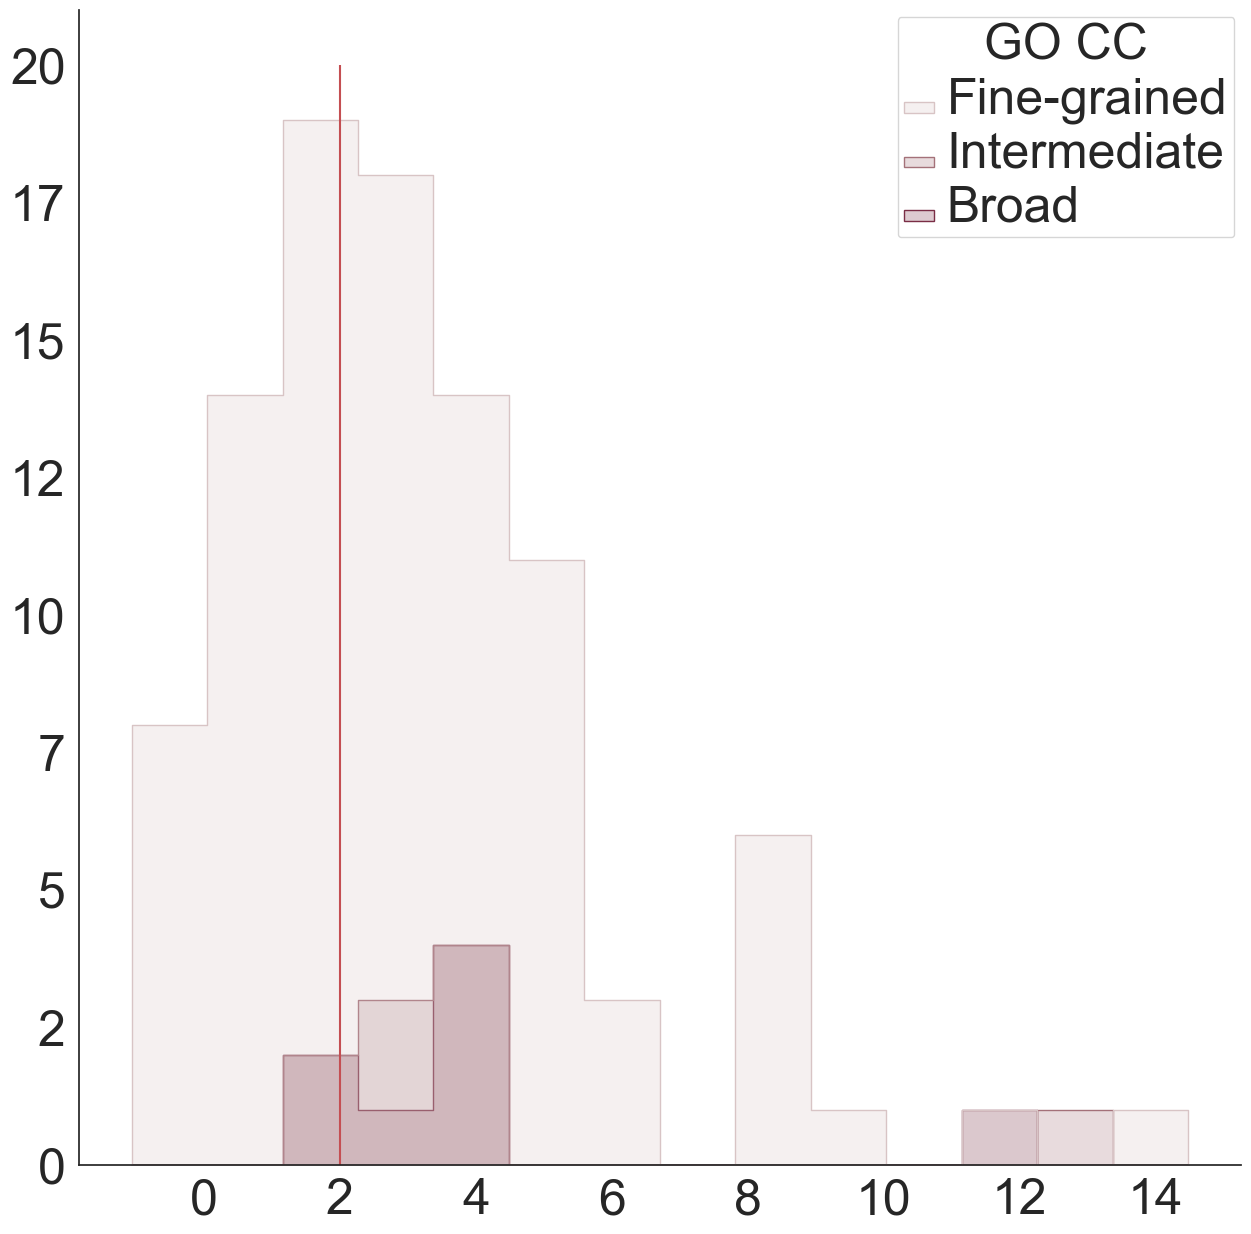

In [40]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_CC_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_CC_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_CC_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_CC_resnik_zscore+middle_CC_resnik_zscore+broad_CC_resnik_zscore
goterms_resnik_zscore_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=20,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO CC", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF18B_3_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [41]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_zscore_df["Color"] = goterms_resnik_zscore_df["GO CC"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    goterms_resnik_zscore_df.to_excel(
        writer,
        sheet_name="SF24B_part3",
        index=False
    )


In [4]:
#Let's import the results
with open('output/Communities/filtered_weighted_emd.pickle', 'rb') as handle:
    filtered_weighted_exp_embeddings = pk.load(handle)

with open('output/Communities/filtered_unweighted_emd.pickle', 'rb') as handle:
    filtered_unweighted_exp_embeddings = pk.load(handle)

with open('output/Communities/unfiltered_unweighted_emd.pickle', 'rb') as handle:
    unfiltered_unweighted_exp_embeddings = pk.load(handle)

with open('output/Communities/unfiltered_weighted_emd.pickle', 'rb') as handle:
    unfiltered_weighted_exp_embeddings = pk.load(handle)

In [5]:

with open('output/Communities/filtered_weighted_node_order.pickle', 'rb') as handle:
    filtered_weighted_node_order = pk.load(handle)


with open('output/Communities/filtered_unweighted_node_order.pickle', 'rb') as handle:
    filtered_unweighted_node_order = pk.load(handle)


with open('output/Communities/unfiltered_weighted_node_order.pickle', 'rb') as handle:
    unfiltered_weighted_node_order = pk.load(handle)


with open('output/Communities/unfiltered_unweighted_node_order.pickle', 'rb') as handle:
    unfiltered_unweighted_node_order = pk.load(handle)

In [6]:
#Let's import the communities calculated with infomap
#Unfiltered-Unweighted
with open('output/Communities/Infomap/im_unfiltered_unweighted_exp_graph_significant_dict.pickle', 'rb') as handle:
    im_unfiltered_unweighted_exp_graph_significant_dict = pk.load(handle)
    
#Unfiltered-Weighted
with open('output/Communities/Infomap/im_unfiltered_weighted_exp_graph_significant_dict.pickle', 'rb') as handle:
    im_unfiltered_weighted_exp_graph_significant_dict = pk.load(handle)

#Filtered-Unweighted
with open('output/Communities/Infomap/im_filtered_unweighted_exp_graph_significant_dict.pickle', 'rb') as handle:
    im_filtered_unweighted_exp_graph_significant_dict = pk.load(handle)

#Filtered-Weighted
with open('output/Communities/Infomap/im_filtered_weighted_exp_graph_significant_dict.pickle', 'rb') as handle:
    im_filtered_weighted_exp_graph_significant_dict = pk.load(handle)


In [8]:
#FILTERED-WEIGHTED

filtered_weighted_infomap_labels = []
for node in filtered_weighted_node_order:
    filtered_weighted_infomap_labels.append(im_filtered_weighted_exp_graph_significant_dict[node])
            
calinski_harabasz_score_val = calinski_harabasz_score(filtered_weighted_exp_embeddings, filtered_weighted_infomap_labels)
davies_bouldin_score_val = davies_bouldin_score(filtered_weighted_exp_embeddings, filtered_weighted_infomap_labels)
sil_score_louvain = silhouette_score(filtered_weighted_exp_embeddings, filtered_weighted_infomap_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:54.14141384079498
davies_bouldin:0.9290053047622943
Silhouette:0.23538272


In [9]:
#FILTERED-UNWEIGHTED

filtered_unweighted_infomap_labels = []
for node in filtered_unweighted_node_order:
    filtered_unweighted_infomap_labels.append(im_filtered_unweighted_exp_graph_significant_dict[node])
            
calinski_harabasz_score_val = calinski_harabasz_score(filtered_unweighted_exp_embeddings, filtered_unweighted_infomap_labels)
davies_bouldin_score_val = davies_bouldin_score(filtered_unweighted_exp_embeddings, filtered_unweighted_infomap_labels)
sil_score_louvain = silhouette_score(filtered_unweighted_exp_embeddings, filtered_unweighted_infomap_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:56.94098927296994
davies_bouldin:1.0076746330901012
Silhouette:0.1941237


In [11]:
#UNFILTERED-WEIGHTED

unfiltered_weighted_infomap_labels = []
for node in unfiltered_weighted_node_order:
    unfiltered_weighted_infomap_labels.append(im_unfiltered_weighted_exp_graph_significant_dict[node])
            
calinski_harabasz_score_val = calinski_harabasz_score(unfiltered_weighted_exp_embeddings, unfiltered_weighted_infomap_labels)
davies_bouldin_score_val = davies_bouldin_score(unfiltered_weighted_exp_embeddings, unfiltered_weighted_infomap_labels)
sil_score_louvain = silhouette_score(unfiltered_weighted_exp_embeddings, unfiltered_weighted_infomap_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:46.45503552566422
davies_bouldin:0.9048523477731975
Silhouette:0.19647059


In [10]:
#UNFILTERED-UNWEIGHTED

unfiltered_unweighted_infomap_labels = []
for node in unfiltered_unweighted_node_order:
    unfiltered_unweighted_infomap_labels.append(im_unfiltered_unweighted_exp_graph_significant_dict[node])
            
calinski_harabasz_score_val = calinski_harabasz_score(unfiltered_unweighted_exp_embeddings, unfiltered_unweighted_infomap_labels)
davies_bouldin_score_val = davies_bouldin_score(unfiltered_unweighted_exp_embeddings, unfiltered_unweighted_infomap_labels)
sil_score_louvain = silhouette_score(unfiltered_unweighted_exp_embeddings, unfiltered_unweighted_infomap_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:46.210491003965906
davies_bouldin:1.0729286163842766
Silhouette:0.08650293


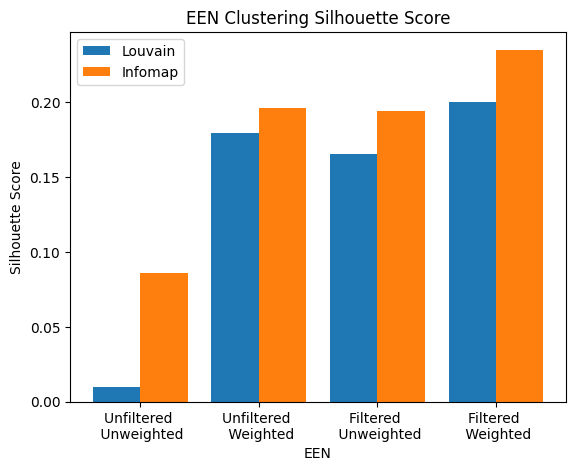

In [14]:
#Let's make the comparison with the Louvain Silhouette across conditions 
#The results can be visualized on the notebook Exp_fin_4_Louvain

labels = ['Unfiltered \n Unweighted', 'Unfiltered \n Weighted', 'Filtered \n Unweighted', 'Filtered \n Weighted']
louvain_silhouette_score = [0.01, 0.179, 0.165, 0.2]
infomap_silhouette_score = [0.086, 0.196, 0.194, 0.235]

# Create the bar plot
X_axis = np.arange(len(labels)) 
  
plt.bar(X_axis - 0.2, louvain_silhouette_score, 0.4, label = 'Louvain') 
plt.bar(X_axis + 0.2, infomap_silhouette_score, 0.4, label = 'Infomap') 


# Add titles and labels
plt.xlabel('EEN')
plt.xticks(X_axis, labels) 
plt.legend() 
plt.ylabel('Silhouette Score')
plt.title('EEN Clustering Silhouette Score')
plt.savefig('output/Figures/SF2E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()

In [4]:

labels = [
    'Unfiltered - Unweighted',
    'Unfiltered - Weighted',
    'Filtered - Unweighted',
    'Filtered - Weighted'
]

louvain_silhouette_score = [0.01, 0.179, 0.165, 0.2]
infomap_silhouette_score = [0.086, 0.196, 0.194, 0.235]

silhouette_df = pd.DataFrame({
    "Condition": labels,
    "Louvain_Silhouette": louvain_silhouette_score,
    "Infomap_Silhouette": infomap_silhouette_score
})

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    silhouette_df.to_excel(
        writer,
        sheet_name="SF6E",
        index=False
    )

print("Source data saved for silhouette score bar plot.")

Source data saved for silhouette score bar plot.


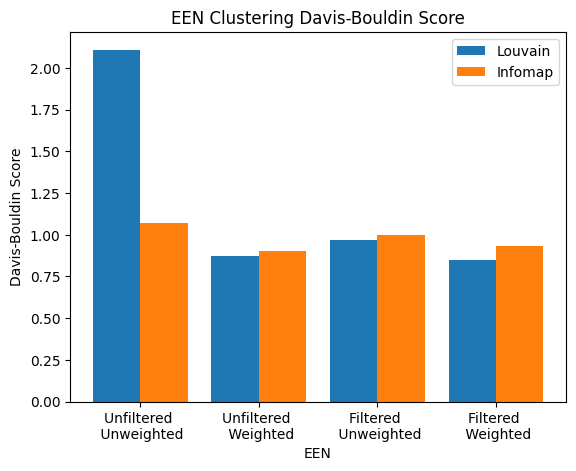

In [15]:
#Let's make the comparison with the Louvain Davies Bouldin across conditions 
#The results can be visualized on the notebook Exp_fin_4_Louvain

labels = ['Unfiltered \n Unweighted', 'Unfiltered \n Weighted', 'Filtered \n Unweighted', 'Filtered \n Weighted']
louvain_db_score = [2.11, 0.87, 0.97, 0.85]
infomap_db_score = [1.07, 0.9, 1, 0.93]

# Create the bar plot
X_axis = np.arange(len(labels)) 
  
plt.bar(X_axis - 0.2, louvain_db_score, 0.4, label = 'Louvain') 
plt.bar(X_axis + 0.2, infomap_db_score, 0.4, label = 'Infomap') 


# Add titles and labels
plt.xlabel('EEN')
plt.xticks(X_axis, labels) 
plt.legend() 
plt.ylabel('Davis-Bouldin Score')
plt.title('EEN Clustering Davis-Bouldin Score')
plt.savefig('output/Figures/SF2F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()

In [5]:

labels = [
    'Unfiltered - Unweighted',
    'Unfiltered - Weighted',
    'Filtered - Unweighted',
    'Filtered - Weighted'
]

louvain_db_score = [2.11, 0.87, 0.97, 0.85]
infomap_db_score = [1.07, 0.9, 1, 0.93]

davis_df = pd.DataFrame({
    "Condition": labels,
    "Louvain_DavisBouldin": louvain_db_score,
    "Infomap_DavisBouldin": infomap_db_score
})

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    davis_df.to_excel(
        writer,
        sheet_name="SF6F",
        index=False
    )

print("Source data saved for silhouette score bar plot.")

Source data saved for silhouette score bar plot.


Gene Part
===

In [ ]:
#Here, we import the unfiltered and the backbone GGN
unfiltered_weighted_gene_graph_significant = nx.read_weighted_edgelist("output/unfiltered_weighted_gene_graph_significant.edgelist")
filtered_weighted_gene_graph_significant = nx.read_weighted_edgelist("output/backbone_gene_graph_significant_weighted.edgelist")


In [43]:

#from https://mapequation.github.io/infomap/python/infomap.html#infomap.InfomapIterator
#for some more examples on infomap: 
#https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=bd65c716de009b259e33715093fca7d27e06699b&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6368726973626c6f65636b65722f696e666f6d61702d6269706172746974652f626436356337313664653030396232353965333337313530393366636137643237653036363939622f6578616d706c65732f707974686f6e2f696e666f6d61702d6578616d706c65732e6970796e62&logged_in=false&nwo=chrisbloecker%2Finfomap-bipartite&path=examples%2Fpython%2Finfomap-examples.ipynb&platform=android&repository_id=176271675&repository_type=Repository&version=99


im = Infomap(silent=True)
mapping = im.add_networkx_graph(filtered_weighted_gene_graph_significant, weight='weight')
im.run()
for modules in sorted(im.get_multilevel_modules().values()):
    print(modules)


(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)


In [44]:
backbone_gene_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    backbone_gene_node_com_dict[mapping[node]]=list(modules)


In [45]:
gg_first_iteration_infomap={}
gg_second_iteration_infomap={}
gg_third_iteration_infomap={}
gg_fourth_iteration_infomap={}

for com in set(im.get_modules(depth_level=1).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=1).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_first_iteration_infomap[com]=node_list 
    
    
for com in set(im.get_modules(depth_level=2).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=2).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_second_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=3).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=3).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_third_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=4).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=4).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_fourth_iteration_infomap[com]=node_list

In [46]:
len(gg_first_iteration_infomap)

64

In [47]:
len(gg_second_iteration_infomap)

429

In [48]:
len(gg_third_iteration_infomap)

461

In [49]:
len(gg_fourth_iteration_infomap)

461

In [50]:
with open('output/Communities/Infomap/gg_first_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(gg_first_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/gg_second_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(gg_second_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/gg_third_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(gg_third_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)


In [51]:
#These communities are the middle and the broad level related to each community

gg_first_level_infomap={}  #middle to fine
for comcom, genelist1 in gg_second_iteration_infomap.items():
    comlist=[]
    for com, genelist2 in gg_third_iteration_infomap.items():
        if len(set(genelist1)&set(genelist2))==len(set(genelist2)):
           comlist.append(com)
    gg_first_level_infomap[comcom]=comlist

gg_second_level_infomap={}  #broad to middle
for comcom, genelist1 in gg_first_iteration_infomap.items():
    comlist=[]
    for com, genelist2 in gg_second_iteration_infomap.items():
        if len(set(genelist1)&set(genelist2))==len(set(genelist2)):
           comlist.append(com)
    gg_second_level_infomap[comcom]=comlist
 

In [52]:
with open('output/Communities/Infomap/gg_ji_first_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(gg_first_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/gg_ji_second_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(gg_second_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)

In [104]:
#Let's import the communities classification created in the notebook
#6_GGN_Infomap_Visualization

with open('output/Communities/Infomap/gg_ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_broad_dict = pk.load(handle)
    
with open('output/Communities/Infomap/gg_ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_middle_dict = pk.load(handle)
    
with open('output/Communities/Infomap/gg_ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_fine_grained_dict = pk.load(handle)
    

#Let's import the 3 hierarchical levels of louvain communities

with open('output/Communities/Louvain/gg_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    gg_Louvain_fine_grained_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_middle_dict.pickle', 'rb') as handle:
    gg_Louvain_middle_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_broad_dict.pickle', 'rb') as handle:
    gg_Louvain_broad_dict = pk.load(handle)
    


In [113]:
#Let's compare these communities

#Fine-grained

common_louvain_finegrained_com_list=[]
for com1,genelist1 in gg_Louvain_fine_grained_dict.items():
    for com2,genelist2 in gg_Infomap_fine_grained_dict.items():
        if len(set(genelist1)&set(genelist2))>=0.99*len(genelist1):
            if len(set(genelist1)&set(genelist2))>=0.99*len(genelist2):
                common_louvain_finegrained_com_list.append(com1)

#Intermediate
common_louvain_middle_com_list=[]
for com1,genelist1 in gg_Louvain_middle_dict.items():
    for com2,genelist2 in gg_Infomap_middle_dict.items():
        if len(set(genelist1)&set(genelist2))>=0.99*len(genelist1):
            if len(set(genelist1)&set(genelist2))>=0.99*len(genelist2):
                common_louvain_middle_com_list.append(com1)

#Broad
common_louvain_broad_com_list=[]
for com1,genelist1 in gg_Louvain_broad_dict.items():
    for com2,genelist2 in gg_Infomap_broad_dict.items():
        if len(set(genelist1)&set(genelist2))>=0.99*len(genelist1):
            if len(set(genelist1)&set(genelist2))>=0.99*len(genelist2):
                common_louvain_broad_com_list.append(com1)


In [114]:
len(common_louvain_finegrained_com_list)/len(gg_Louvain_fine_grained_dict)

0.44106463878326996

In [115]:
len(common_louvain_finegrained_com_list)/len(gg_Infomap_fine_grained_dict)

0.25162689804772237

In [62]:
bipartite_G = nx.Graph()
exposures_list = []
genes_list = []
for k,v in chem_gene_cleaned.items():
    if str(k)!='nan':
        exposures_list.append(k)
        for gene in v:
            if str(gene)!='nan':
                genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G.add_node(exposure,s="o", bipartite='exposure')
    for genes in [i for i in chem_gene_cleaned[exposure] if str(i)!='nan']:
        bipartite_G.add_edges_from([(exposure,genes)])
        
bipartite_G_node_list = list(bipartite_G.nodes())

mapping_bipartite_G_node = {}
for el in range(len(bipartite_G_node_list)):
    mapping_bipartite_G_node[bipartite_G_node_list[el]] = el


In [69]:
#Let's write a text file with the combined Louvain communities identified by Louvain and Infomap in the projected networks
#These will be the starting point to search new co-cluster communities in the bipartite graph directly

with open('intermediate/bipartite_G_edges_float_MiddleInfomap_initial_comm_both.txt', 'w') as f:
    for com, nodeset in gg_Infomap_middle_dict.items():
        nodelist = list(nodeset)
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")
    for com, nodelist in infomap_middle_communities_dict.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

with open('intermediate/bipartite_G_edges_float_FineInfomap_initial_comm_both.txt', 'w') as f:
    for com, nodeset in gg_Infomap_fine_grained_dict.items():
        nodelist = list(nodeset)
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")
    for com, nodelist in infomap_fine_grained_communities_dict.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

In [70]:


gg_Infomap_fine_grained_df = pd.DataFrame.from_dict(gg_Infomap_fine_grained_dict, orient='index').T
gg_Infomap_middle_df = pd.DataFrame.from_dict(gg_Infomap_middle_dict, orient='index').T
gg_Infomap_broad_df = pd.DataFrame.from_dict(gg_Infomap_broad_dict, orient='index').T

gg_Infomap_fine_grained_df.to_csv("output/gg_Infomap_fine_grained.tsv")
gg_Infomap_middle_df.to_csv("output/gg_Infomap_middle.tsv")
gg_Infomap_broad_df.to_csv("output/gg_Infomap_broad.tsv")

In [71]:
#Let's try to associate some exposures or some chemical class to these communities
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(set(setA))
    N= len(set(setB))
    x= len(set(setA).intersection(set(setB)))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used



In [72]:
significant_gg_Infomap_broad_dict = {}
for com,gene_set in gg_Infomap_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_broad_dict[com]= significant_chem_class
    
significant_gg_Infomap_middle_dict={}
for com,gene_set in gg_Infomap_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_middle_dict[com]= significant_chem_class
    
significant_gg_Infomap_fine_grained_dict={}
for com,gene_set in gg_Infomap_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_fine_grained_dict[com]= significant_chem_class
    
    

In [73]:
#Let's run some biological enrichments

gg_Infomap_fine_grained_dict_enrichment={}
gg_Infomap_middle_dict_enrichment={}
gg_Infomap_broad_dict_enrichment={}
enrichment_libraries = ['GO_Cellular_Component_2023','GO_Molecular_Function_2023','GO_Biological_Process_2023','KEGG_2021_Human']



import requests
import json
for com,genelist in gg_Infomap_fine_grained_dict.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    gg_Infomap_fine_grained_dict_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_Infomap_middle_dict.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    gg_Infomap_middle_dict_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_Infomap_broad_dict.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    gg_Infomap_broad_dict_enrichment[com]=enriched_terms_specific_net

In [123]:
column_names = ["Enriched Term", "FDR"]

for broad_com,enr_list in gg_Infomap_broad_dict_enrichment.items():
    gg_enr_df = pd.DataFrame(columns = column_names)
    for el in enr_list:
        new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
        gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)

    if len(significant_gg_Infomap_broad_dict[broad_com])>0:
        for el in significant_gg_Infomap_broad_dict[broad_com]:
            new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
            gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)
    gg_enr_df.to_csv("output/Communities/Infomap/GGN Enrichment/gg_Infomap_%s_enrichment.tsv"%broad_com)

for middle_com,enr_list in gg_Infomap_middle_dict_enrichment.items():
    gg_enr_df = pd.DataFrame(columns = column_names)
    for el in enr_list:
        new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
        gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)

    if len(significant_gg_Infomap_middle_dict[middle_com])>0:
        for el in significant_gg_Infomap_middle_dict[middle_com]:
            new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
            gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)
    gg_enr_df.to_csv("output/Communities/Infomap/GGN Enrichment/gg_Infomap_%s_enrichment.tsv"%middle_com)


for fg_com,enr_list in gg_Infomap_fine_grained_dict_enrichment.items():
    gg_enr_df = pd.DataFrame(columns = column_names)
    for el in enr_list:
        new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
        gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)

    if len(significant_gg_Infomap_fine_grained_dict[fg_com])>0:
        for el in significant_gg_Infomap_fine_grained_dict[fg_com]:
            new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
            gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)
    gg_enr_df.to_csv("output/Communities/Infomap/GGN Enrichment/gg_Infomap_%s_enrichment.tsv"%fg_com)

